# Temporal Convolution Neural Network with Conditioning for Broad Market Signals


<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


In this article, we will build a Temporal Convolusion Network (TCN) for binary classification, which will learn and predict the market direction day by day, if its bullish or bearish.

Convolutional neural networks (CNNs) are commonly used for image classification, as the spectral convolutions can extract features and patterns. The same is applicable to timeseries, as proven by the seminal paper from Oord et al. describing Google's Deepmind WaveNet architecture (paper and code in the reference section). We will borrow concepts from WaveNet to teach it to identify deep structures in the markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

os.getcwd()

C:\Users\adamd\AppData\Local\Temp\ipykernel_17120\3477214583.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Running Local...


'c:\\Users\\adamd\\workspace\\quant_research'

# Financial Data

Using `yfinance`, we will pull 20 years of market data, specifically: 
- **SPY** ETF - which will be our target.
- CBoE's **VIX** as a proxy for market senitment and volatility.
- The **Russell500** small caps index, as a proxy for speculation.
- The **Gold index** as proxy for investor uncertainty.
- The **10 year US treasury note** as proxy for inflation and rates.

In [2]:
from datetime import datetime
from scipy.stats import skew, kurtosis
from pandas.tseries.offsets import BDay

START_DATE = "1999-01-01"
END_DATE = pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "data"
INDEX = "Date"
TARGET_ETF = "SPY"  # S&P 500
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
SMALLCAP_INDEX = "^RUT" # Russell 2000 Index
GOLD_INDEX = "GC=F" # Gold futures
tickers_symbols = [
    TARGET_ETF,
    VOLATILITY_INDEX,
    RATES_INDEX,
    SMALLCAP_INDEX,
    GOLD_INDEX,
]
INTERVAL = "1d"

def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_csv(cached_file_path, index_col=INDEX)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_csv(cached_file_path)
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(tickers_symbols)

SPY => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:0.24, skewness:1.18, outliers_count:0,  nan_count: 0
^VIX => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:7.8, skewness:2.12, outliers_count:100,  nan_count: 0
^TNX => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.78, skewness:0.18, outliers_count:0,  nan_count: 0
^RUT => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.5, skewness:0.77, outliers_count:0,  nan_count: 0
GC=F => min_date: 2000-08-30 00:00:00, max_date: 2024-02-08 00:00:00, kurt:-1.18, skewness:-0.15, outliers_count:0,  nan_count: 0


In [3]:
print(f"Date ranges {latest_start} - {earliest_end}")
for ticker in tickers_symbols:
    df = tickers.get(ticker)
    df = df[(df.index >= latest_start) & (df.index <= earliest_end)]

    assert len(df) > 0 and not df.isna().any().any()

    tickers[ticker] = df

tickers.get(TARGET_ETF).head(5)

Date ranges 2000-08-30 00:00:00 - 2024-02-07 00:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,151.3125,151.500000,150.34375,150.34375,97.524689,3964800
2000-08-31,151.0625,153.093750,150.90625,152.34375,98.822105,4863100
2000-09-01,153.2500,153.593750,152.00000,152.50000,98.923454,3191200
2000-09-05,151.8750,152.203125,150.81250,151.28125,98.132874,3470800
2000-09-06,151.1875,151.953125,149.53125,149.56250,97.017929,4322200


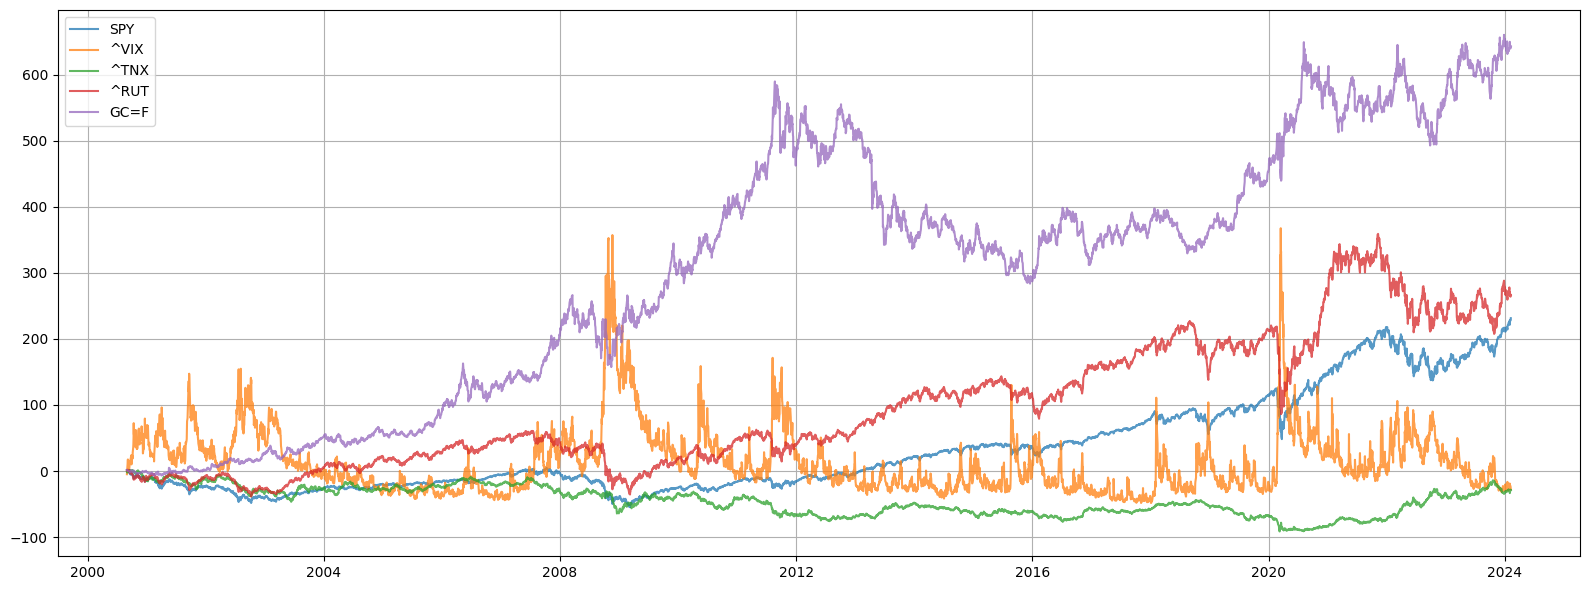

In [4]:
percentage_returns = {}

for ticker in tickers_symbols:
    df = tickers.get(ticker)
    percentage_returns[ticker] = ((1 + df["Close"].pct_change()).cumprod() - 1) * 100
plt.figure(figsize=(16, 6))
for ticker, pr in percentage_returns.items():
    plt.plot(pr, label=ticker, alpha=0.75)

plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# Naive Baseline Strategy

Most financial gurus would want to persuade you that their easy 2-point strategy is a winner, the latest being buying leveraged ETFs or their futures at market open and selling at close, betting that the laws of large numbers give you a good return.

Let's test this:

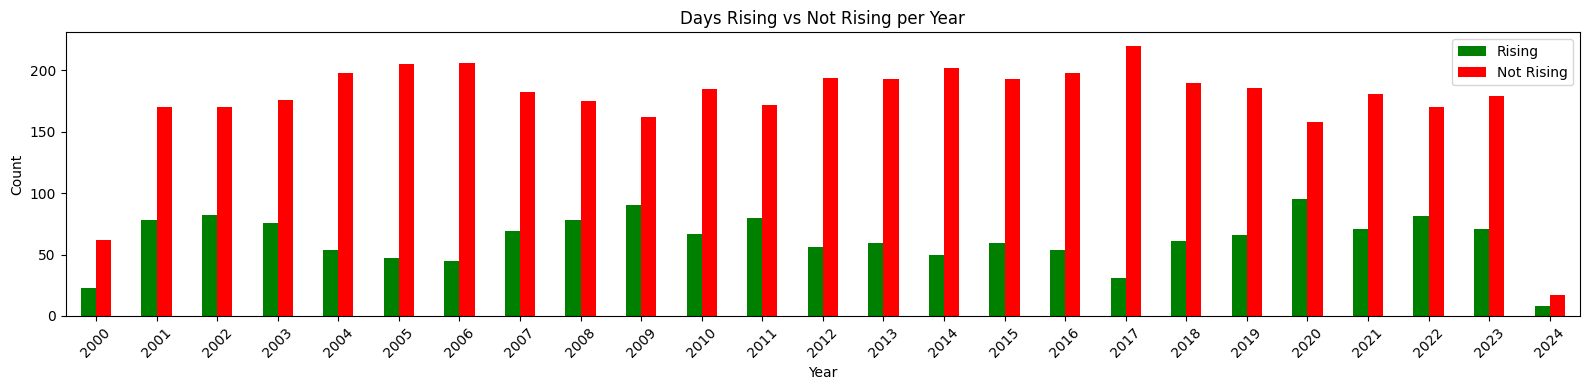

Baseline Accuracy: 26.48%


In [5]:
TARGET_FACTOR = 55/100/100  # assume 55BP spread on average

target_etf = tickers.get(TARGET_ETF)

next_close = (target_etf["Close"].shift(-1) * (1- TARGET_FACTOR))
days_rising = target_etf[next_close > target_etf["Close"]]
days_not_rising = target_etf[next_close <= target_etf["Close"]]
days_rising_count = days_rising.groupby(days_rising.index.year).size()
days_not_rising_count = days_not_rising.groupby(days_not_rising.index.year).size()

total_days = target_etf.groupby(target_etf.index.year).size()
percentage_rising = (days_rising_count / total_days) * 100

yearly_counts = pd.DataFrame(
    {"Rising": days_rising_count, "Not Rising": days_not_rising_count}
)
yearly_counts.plot(kind="bar", color=["green", "red"], figsize=(16, 4))
plt.title("Days Rising vs Not Rising per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tick_params(axis="x", rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Baseline Accuracy: {percentage_rising.mean():0.2f}%")

Therefore, we have 29% of making a profit with this strategy, such a low ROI because we are factoring in a 50 basis points spread, and various fees and commisions the broker would charge us. 

We know the NN is succesful if its precision score beats 29%

# Feature Selection and Engineering

## Feature Constants

In [6]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, normalize

MONTH_SINE = "month_sin"
MONTH_COS = "month_cos"
MONTH_RBF = "month_rbf"
DAY_SINE = "day_sin"
DAY_COS = "day_cos"
DAY_RBF = "day_rbf"
Q_SINE = "quart_sin"
Q_COS = "quart_cos"
Q_RBF = "quart_rbf"
BIZ_SINE = "biz_sin"
BIZ_COS = "biz_cos"
BIZ_RBF = "biz_rbf"
TARGET_LABEL = "Close_target"
TARGET_TS = "Close"  # The TS which we will condition.
EXOG_TS = tickers_symbols.copy() # The TS to use for conditioning
EXOG_TS.remove(TARGET_ETF)
PRICE_FEATURES = ["Open", "High", "Low", "Close"]
TIME_FEATURES = [
    DAY_RBF,
    MONTH_RBF,
    Q_RBF,
    BIZ_RBF,
]
TS_FEATURES = ["Volume"]
TARGET_TS_FEATURES_NOTIME = EXOG_TS + TS_FEATURES + PRICE_FEATURES
TARGET_TS_FEATURES = TARGET_TS_FEATURES_NOTIME + TIME_FEATURES
WINDOW_SIZE = 252 // 4  # 1 years trading, sampled across days
PREDICTION_HORIZON = 1  # next 1 trading day

print(f"target factor used: {TARGET_FACTOR} for window: {WINDOW_SIZE} predicting: {PREDICTION_HORIZON} step")

target factor used: 0.0055000000000000005 for window: 63 predicting: 1 step


Neural Networks (NN) see numbers differently than us, they are interested in magnitudes, cycles and distances, this means we have to encode our data in a way that makes NN learning easy.

Through out the experiments we used log returns (capturing percentage moves): $r_t = \log\left(\frac{P_t}{P_{t-1}}\right)$, first order of integration (differencing the values of today with yesterday): $Y_t = \sum_{i=0}^{t} \Delta X_i$, and finally only normalizing the raw data: $X_{\text{norm}} = \frac{X - \mu}{\sigma}$. We chose the raw data, as the nature of the TCN is unaffected by the data's representation as long as its normalized - we'll revisit this in the architecture below.

Time took a different approach, since time is cyclic (even years, you can think of these as business cycles) it can be encoded into sin/cosine waves, for example days can be encoded in the following equation:

$$
\text{sin}_{d} = \sin\left(\frac{2\pi d}{365}\right)
\newline
\text{cos}_{d} = \cos\left(\frac{2\pi d}{365}\right)
$$

A more accurate representation of time are Radial Basis Functions (RBF) $K(d, d') = \exp\left(-\frac{(d - d')^2}{2\sigma^2}\right)$, accurate because Sunday is larger than Monday, which the cyclic function fails to represent this while the RBF one gives the right distance representation.


In [7]:

def create_time_features(data_df):
    """
    Encodes time cyclic features for a dataset with monthly sampling.
    Including cyclic encoding for day and year.
    :param data_df: The timeseries with a date in the format YYYY-MM-DD as index.
    :return: data_df with added wave features for month, day, and year.
    """
    if not isinstance(data_df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")

    def _sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

    def _cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    def rbf_transform(x, period, input_range):
        x_normalized = (x - input_range[0]) / (input_range[1] - input_range[0]) * period
        return np.exp(-0.5 * ((x_normalized - period / 2) / 1.0) ** 2)

    data_df[DAY_RBF] = rbf_transform(data_df.index.day, 31, (1, 31))
    data_df[MONTH_RBF] = rbf_transform(data_df.index.month, 12, (1, 12))
    data_df[Q_RBF] = rbf_transform((data_df.index.month - 1) // 3 + 1, 4, (1, 4))
    min_year, max_year = data_df.index.year.min(), data_df.index.year.max()
    data_df[BIZ_RBF] = rbf_transform(
        data_df.index.year, max_year - min_year, (min_year, max_year)
    )

    return data_df

def create_features_df(tickers, data_df, target_label=TARGET_ETF):
    """
    Create all exogenous features that lead to our target etf.
        - if the trading day close is higher than the open.
        - price log returns or 1D integrations.
    :param tickers: All the timeseries with a date in the format YYYY-MM-DD as index.
    :param data_df: Any pre-engineered features.
    :return: data_df With TARGET_LABEL timeseries at column 0, and the rest are for conditioning.
    """

    def _get_first_difference(data_df):
        return data_df.pct_change().fillna(0)

    def _get_log_returns(data_df):
        return np.log(data_df / data_df.shift(1)).fillna(0)

    IDX_COL = "Open"
    price_transform = FunctionTransformer(_get_first_difference)

    data_df[PRICE_FEATURES] = price_transform.fit_transform(data_df[PRICE_FEATURES])
    rates_df = tickers.get(RATES_INDEX)

    for index in EXOG_TS:
        if index == target_label:
            continue
        index_df = tickers.get(index)
        transformed_data = price_transform.fit_transform(index_df[[IDX_COL]])
        data_df[index] = transformed_data

    data_df = data_df.fillna(0)

    return data_df

IS_CLASSIFICATION = True

def prepare_data(tickers, target_label=TARGET_ETF, classify=IS_CLASSIFICATION, to_normalize=True):
    """
    Utility function to prepare the data.
    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.
    :param window_size: int, length of the input sequence
    :param horizon: int, forecasting horizon, defaults to 1
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    y_scaler = None, None
    data_df = tickers.get(target_label).copy()
    close_tomorrow_df = (data_df['Close'].shift(-1) * (1- TARGET_FACTOR))
    if classify:
        today_df = data_df['Close'] # data_df['Open'].shift(-1)
        # Calculate the target label: 1 if next day's close is higher than its open.
        data_df[TARGET_LABEL] = (close_tomorrow_df > today_df).astype(int)
    else:
        # A target variable with a large spread of values, in turn, may result in large error gradient values
        # causing weight values to change dramatically. We predict tomorrows close.
        y_scaler = MinMaxScaler(feature_range=(-1, 1))
        y_scaled = y_scaler.fit_transform(close_tomorrow_df)
        data_df[TARGET_LABEL] = y_scaled.flatten()

    data_df = create_features_df(tickers, data_df, target_label=target_label)
    data_df_normalized = None
    if to_normalize:
        data_df_normalized = normalize(data_df[TARGET_TS_FEATURES_NOTIME], norm="l2")
    else:
        data_df_normalized = data_df[TARGET_TS_FEATURES_NOTIME]
    data_df_normalized = pd.DataFrame(
        data_df_normalized, columns=TARGET_TS_FEATURES_NOTIME
    )
    data_df_normalized = pd.concat(
        [
            data_df[TARGET_LABEL].reset_index(drop=True),
            data_df_normalized.reset_index(drop=True),
        ],
        axis=1,
    )
    if any(feature in TIME_FEATURES for feature in TARGET_TS_FEATURES):
        # Don't normalize these.
        data_df = create_time_features(data_df)
        data_df_normalized = pd.concat(
            [
                data_df[TIME_FEATURES].reset_index(drop=True),
                data_df_normalized.reset_index(drop=True),
            ],
            axis=1,
        )
    # we might drop the first and last row of data (shifts and difference => NAs)
    return data_df_normalized.dropna(axis=0), y_scaler

data_df, y_scaler = prepare_data(tickers, to_normalize=True)
data_df.head(15)

,day_rbf,month_rbf,quart_rbf,biz_rbf,Close_target,^VIX,^TNX,^RUT,GC=F,Volume,Open,High,Low,Close
0,3.584762e-46,0.262149,0.800737,5.380186e-32,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,6.766676e-53,0.262149,0.800737,5.380186e-32,0,3.721286e-09,-1.201067e-09,1.059922e-09,6.756695e-10,1.0,-3.397442e-10,2.163188e-09,7.693500e-10,2.735467e-09
2,6.766676e-53,0.024258,0.800737,5.380186e-32,0,-1.131985e-08,-3.844602e-09,3.255128e-09,2.508733e-09,1.0,4.537717e-09,1.023431e-09,2.271208e-09,3.213967e-10
3,8.797012e-29,0.024258,0.800737,5.380186e-32,0,4.062106e-08,-6.048706e-10,2.153270e-09,-1.248177e-09,1.0,-2.585072e-09,-2.608596e-09,-2.250922e-09,-2.302582e-09
4,6.508789e-24,0.024258,0.800737,5.380186e-32,1,6.272638e-09,-3.650477e-10,-1.233840e-09,-1.342191e-09,1.0,-1.047325e-09,-3.800245e-10,-1.965584e-09,-2.628589e-09
5,1.655523e-19,0.024258,0.800737,5.380186e-32,0,9.163338e-09,1.564284e-09,-1.174332e-09,-1.710090e-10,1.0,-1.453736e-09,-1.349984e-09,4.654486e-10,2.008358e-09
6,1.447572e-15,0.024258,0.800737,5.380186e-32,0,-2.304993e-08,-2.478769e-10,3.444838e-09,-7.261637e-10,1.0,5.911736e-11,-1.087676e-09,-9.485411e-10,-1.943194e-09
7,1.597258e-06,0.024258,0.800737,5.380186e-32,0,2.970406e-09,3.990345e-10,-3.331220e-09,-1.858361e-10,1.0,-8.977875e-10,1.160154e-09,-1.089536e-09,-3.708339e-10
8,1.950563e-04,0.024258,0.800737,5.380186e-32,0,-7.712999e-09,7.675314e-10,-8.141582e-10,-1.535672e-10,1.0,0.000000e+00,-1.300226e-09,-3.525568e-10,-1.533092e-09
9,8.188701e-03,0.024258,0.800737,5.380186e-32,0,3.049928e-09,0.000000e+00,-2.899339e-10,-4.764379e-11,1.0,-1.519338e-09,-7.841820e-10,-6.842735e-10,3.419927e-10


## Data Analyis & Feature Selection

let's start with a simple check, if we are to predict the number of days the target instrument (SPY in our case) closes higher than the start (we know already its 29% of the time) if we actor in spreads and fees, is our data set balanced?

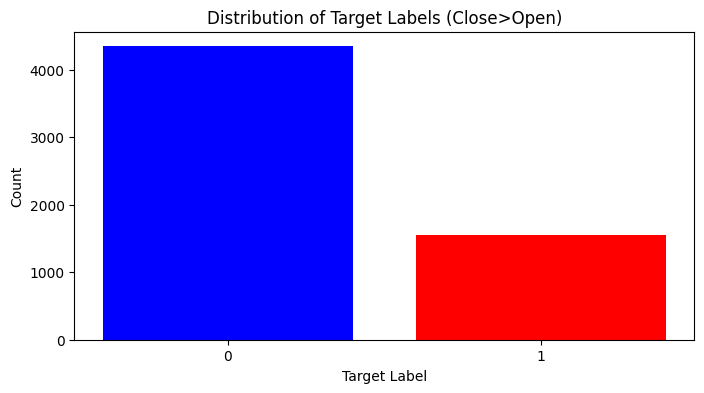

In [8]:
label_counts = data_df[TARGET_LABEL].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(label_counts.index.astype(str), label_counts.values, color=['blue', 'red'])
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.title('Distribution of Target Labels (Close>Open)')
plt.xticks([0, 1])
plt.show()

No its not - this is can be a problem for the NN as it can get biased on the 0 label (not higher than the start). In this case we have to use a specific loss function called Focal Loss as an alternative to the standard Cross-Enthropy. Focal distances will penalize the easier classiications, and therefore balance the model's training.  The binary focal loss can be expressed as:

$$
\text{FL}(p_t) = -\alpha_t (1 - p_t)^\gamma \log(p_t)
$$
- FLpt represents the focal loss for the probability pt.
- alpha t is the wieghting for importance, addressing the imbalance.
- gama is the focusing parameter.
- pt is the estimate for the positive label (1 in our case)
- log pt is the probabilities log.

### PCA Analysis

We carry out a PCA to assert which features have most info to our target, and attempt to identify anomalies in our timeseries.

Let's start with a timeseries definition: An interdependant multiplicative timeseries (as most financial timeseries are) is comprised of 4 components:

$Y(t)=T(t)×S(t)×C(t)×\epsilon(t)$

Where $T$ is the trend, $S$ is the seasonal trend, $C$ is the cyclical trend and $\epsilon$ is noise in any point in time $t$. The additive version (no dependant components) would substitute the operator to $+$. We know that all our data is:
1. Autoregressive and probably multicollinear
2. Not stationary, the mean moves.
3. Has trend, seasonality and all manner of noisome structures.

With this in mind, PCA will decompose these into components of meaningful variance. The cummulative variance signals which features are of importance in our data and which will contribute most information. 

Max components for 95.0% variance: 4 out of 14


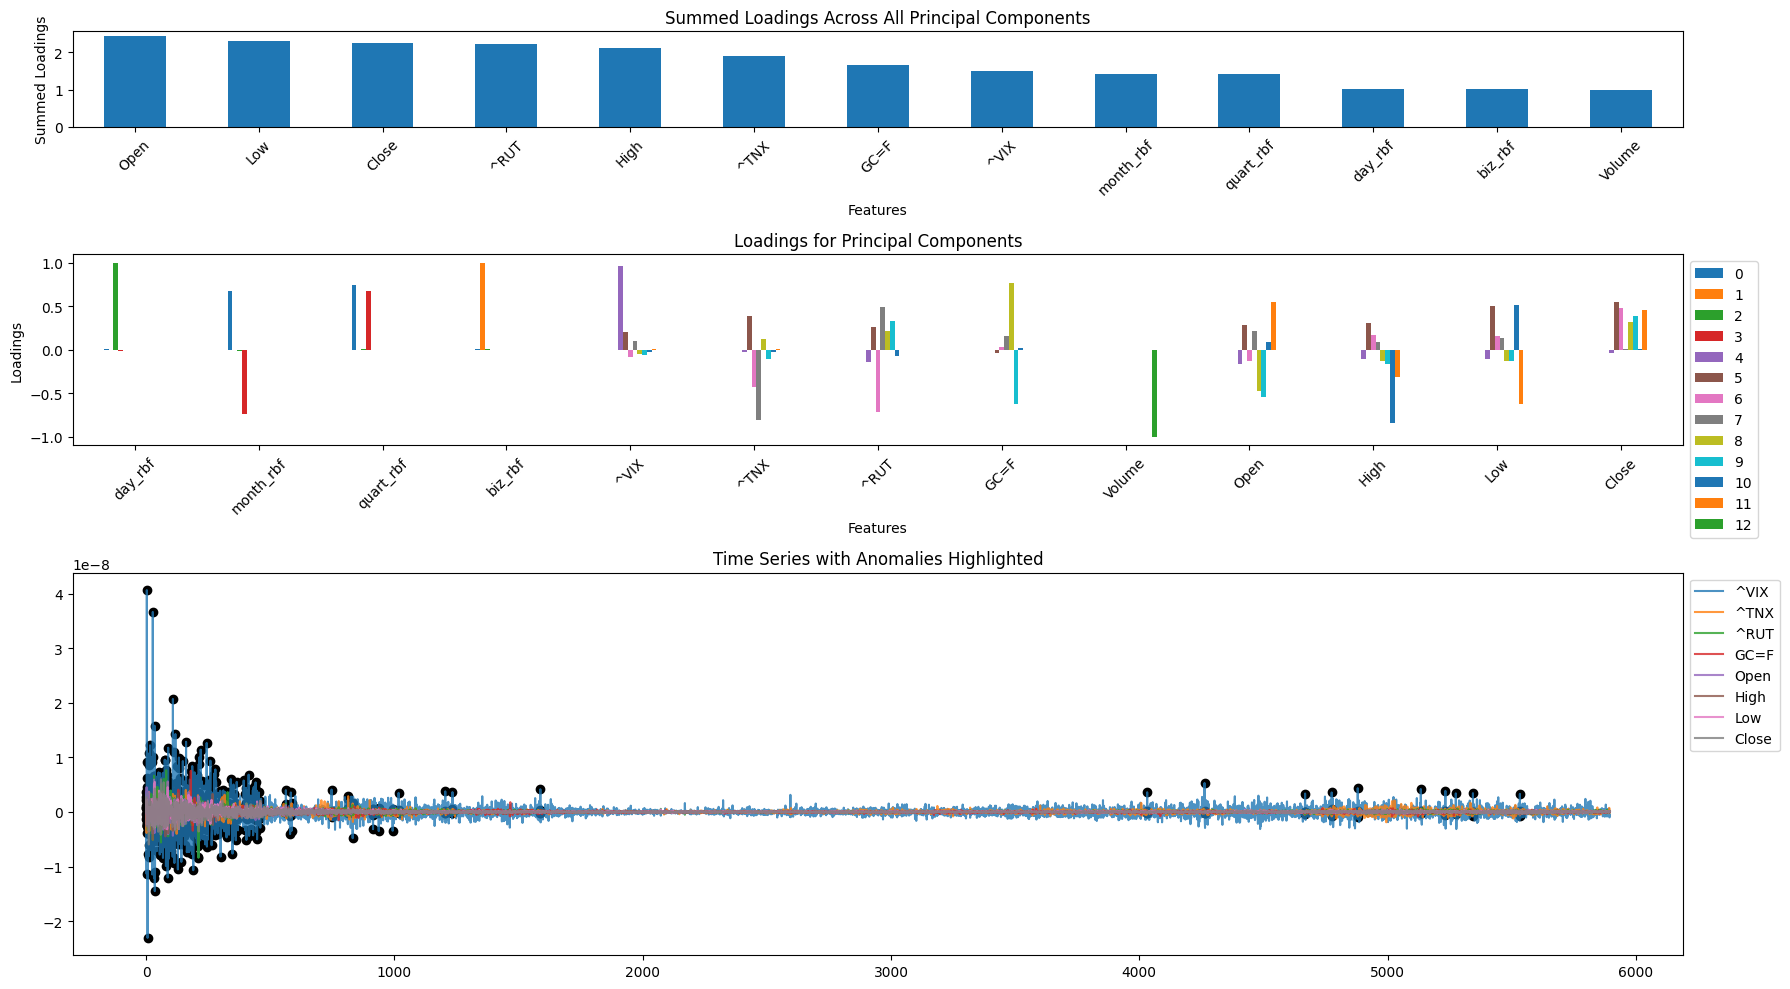

In [9]:
from sklearn.decomposition import PCA

MAX_VARIANCE = 0.95


data_df_pca = data_df.drop(columns=[TARGET_LABEL])
pca = PCA()
xdata = pca.fit_transform(data_df_pca)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cum_var_exp >= MAX_VARIANCE) + 1
print(f"Max components for {MAX_VARIANCE*100}% variance: {num_components} out of {data_df.shape[1]}")

eigenvectors = pca.components_
loadings_df = pd.DataFrame(eigenvectors, columns=data_df_pca.columns).T
summed_loadings = np.sum(np.abs(eigenvectors), axis=0)
summed_loadings_df = pd.DataFrame(summed_loadings, index=data_df_pca.columns, columns=["Sum"]).sort_values(by="Sum", ascending=False)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10), gridspec_kw={'height_ratios': [1, 2, 4]})

summed_loadings_df.plot(kind="bar", legend=False, ax=axes[0])
axes[0].set_title("Summed Loadings Across All Principal Components")
axes[0].set_ylabel("Summed Loadings")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis='x', labelrotation=45)


loadings_df.plot(kind="bar", legend=False, ax=axes[1])
axes[1].set_title(f"Loadings for Principal Components")
axes[1].set_ylabel("Loadings")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis='x', labelrotation=45)
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

pca_reduced = PCA(n_components=num_components)
xdata_reduced = pca_reduced.fit_transform(data_df_pca)
xdata_projected = pca_reduced.inverse_transform(xdata_reduced)
error = np.sum((data_df_pca - xdata_projected) ** 2, axis=1)
anomaly_threshold = np.percentile(error, MAX_VARIANCE*100)
anomalies = error > anomaly_threshold

data_df_pca = data_df.copy()
anomaly_dates = data_df.index[np.where(anomalies)]
for i, column in enumerate(data_df_pca.columns):
    if column == TARGET_LABEL or column in TIME_FEATURES or column == "Volume":
        continue
    axes[2].scatter(anomaly_dates, data_df_pca.loc[anomaly_dates, column], label='Anomaly' if i == 0 else "__nolegend__", color='k')
    axes[2].plot(data_df_pca.index, data_df_pca[column], label=f'{column}', alpha=0.8)
axes[2].set_title('Time Series with Anomalies Highlighted')
axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

By using PCA we can deconstrcut and reconstruct with reduced components to indentify variance and therefore anomalies. These are plotted in the chart above, with the black circles signalling outliers above the 95th percentile

The chart is interesting, the market movements during the 2008 global recession were relatively uniform across all sectors (broad market downturn), returns might move together in a way that **PCA considers normal**. In contrast, the periods of 2000-2005 (dotCOM bubble) and post-2019 (Covid) have exhibited more varied behaviors across these indices, leading to higher reconstruction errors for those periods.

We also use the Information Coefficient (IC), calculated here using **Spearman's rank correlation** to understand the feature importance. It measures the strength and direction of a monotonic relationship between two variables. IC is useful because it can capture nonlinear relationships between variables. A high absolute value of the IC indicates a strong relationship, which could be either positive or negative. Spearman's rank is represented by the following formula:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

- Where the sum of d represents the sum of the squared differences in ranks between each pair of observations.
- n is the number of observations.
- The constant 6 is part of the normalization factor that scales the sum of squared rank differences.

The Mutual Information (MI) also quantifies the amount of information obtained about one random variable through observing the other random variable. It's measuring how much information each feature in our dataset provides about the target variable. Unlike correlation, MI can capture any kind of relationship between variables, not just linear or monotonic. MI between X and Y can be represented by the formula:

$$
I(X; Y) = \sum_{y \in Y} \sum_{x \in X} p(x, y) \log \left( \frac{p(x, y)}{p(x)p(y)} \right)
$$

- p(x,y) is the joint probability distribution function of X and Y, indicating the probability that X takes on value x and Y takes on value y simultaneously.
- p(x) and p(y) are the marginal probability distribution functions of X and Y, respectively, indicating the probabilities of X taking on value x and Y taking on value y independently.

Many good things come from feature selection: less change of over-fitting, faster training times, more accurate models - though sometimes at the cost of interpretability. In our case all features are deemed important within an economic context, though we ought to finetune a bit in the next section. The graph below represents the IC and MI of our current features:

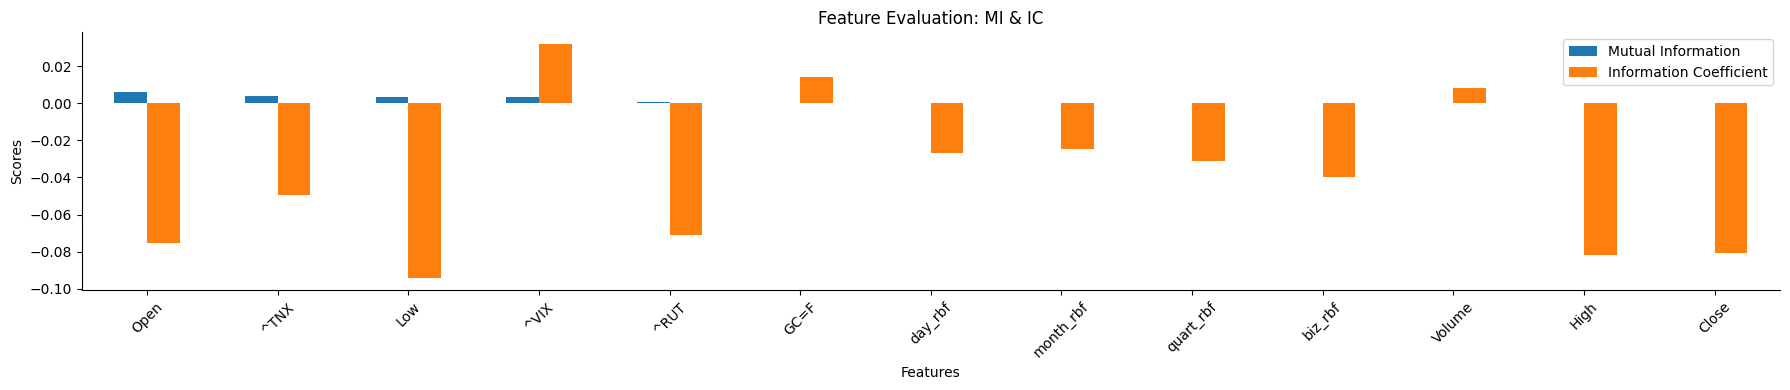

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

ic = {}
for column in data_df.columns:
    if column != TARGET_LABEL:
        corr, p_val = spearmanr(data_df[TARGET_LABEL], data_df[column])
        ic[column] = [corr, p_val]

ic_df = pd.DataFrame(ic, index=["IC", "p-value"]).T

mi = mutual_info_regression(X=data_df.drop(columns=[TARGET_LABEL]), y=data_df[TARGET_LABEL])
mi_series = pd.Series(mi, index=data_df.drop(columns=[TARGET_LABEL]).columns)
metrics = pd.concat(
    [
        mi_series.to_frame("Mutual Information"),
        ic_df["IC"].to_frame("Information Coefficient"),
    ],
    axis=1,
)
metrics = metrics.sort_values(by="Mutual Information", ascending=False)
ax = metrics.plot.bar(figsize=(18, 4), rot=45)
ax.set_xlabel("Features")
ax.set_ylabel("Scores")
ax.set_title("Feature Evaluation: MI & IC")
sns.despine()
plt.tight_layout()
plt.show()

## Feature Selection

Let's do a union of the important features from both PCA and IC/MI methods, with the assumption that only these are what the model needs.

There are other checks we can do, such as correlation and cointegration, plus checking their T-scores. Sadly in earlier experiments, this feature set was too simple for the model, causing it to have high bias. We will train it with the full load.

In [11]:
MAX_FEATURES_COUNT = 10

features_pca = summed_loadings_df.head(MAX_FEATURES_COUNT).index.tolist()
features_miic = (metrics.head(MAX_FEATURES_COUNT).index.tolist())
print(F"Top {MAX_FEATURES_COUNT} PCA Loadings: {features_pca}")
print(F"Top {MAX_FEATURES_COUNT} MI/IC: {features_miic}")
SELECTED_FEATURES = list(set(features_pca) & set(features_miic))

print(f"Selected {len(SELECTED_FEATURES)} features: {SELECTED_FEATURES}")

Top 10 PCA Loadings: ['Open', 'Low', 'Close', '^RUT', 'High', '^TNX', 'GC=F', '^VIX', 'month_rbf', 'quart_rbf']
Top 10 MI/IC: ['Open', '^TNX', 'Low', '^VIX', '^RUT', 'GC=F', 'day_rbf', 'month_rbf', 'quart_rbf', 'biz_rbf']
Selected 8 features: ['^VIX', '^TNX', 'GC=F', 'quart_rbf', 'Open', 'Low', 'month_rbf', '^RUT']


In [12]:
SELECTED_EXOG =  EXOG_TS # [feature for feature in SELECTED_FEATURES if feature in EXOG_TS] #
SELECTED_FEATURES = data_df.drop(columns=EXOG_TS+["Open", "Volume"], axis=1).columns.to_list() # [feature for feature in SELECTED_FEATURES if feature not in EXOG_TS +["Open", "Volume"])] #

SELECTED_EXOG, SELECTED_FEATURES

(['^VIX', '^TNX', '^RUT', 'GC=F'],
 ['day_rbf',
  'month_rbf',
  'quart_rbf',
  'biz_rbf',
  'Close_target',
  'High',
  'Low',
  'Close'])

Finally, to make sure we have only features that contribute new information, we test for multicolinearity with Variance Inflation Factor (VIF): $VIF_i = \frac{1}{1 - R_i^2}$ where Ri coefficient of determination of a regression. For feature not to be colinear, they have to score between 1 to 5 (ignoring the constant term which we placed there for an intercept to help in the variance calculation):

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_with_constant = add_constant(data_df[SELECTED_FEATURES + SELECTED_EXOG])
vif_data = pd.DataFrame()
vif_data["feature"] = data_with_constant.columns
vif_data["VIF"] = [
    variance_inflation_factor(data_with_constant.values, i)
    for i in range(data_with_constant.shape[1])
]

print(vif_data)

         feature       VIF
0          const  3.785721
1        day_rbf  1.001582
2      month_rbf  1.599624
3      quart_rbf  1.600373
4        biz_rbf  1.000497
5   Close_target  1.003715
6           High  2.247700
7            Low  2.953168
8          Close  2.392608
9           ^VIX  1.804647
10          ^TNX  1.074184
11          ^RUT  1.503361
12          GC=F  1.034004


# Temporal Convolution Neural Network (TCN)

CNNs, RNNs and other stateful deeplearning models are used for timeseries (including transformers, as language is also a timeseries). The TCN is made specifically for timeseries problems, following the paper's architecture - we also migrate their code to tensorflow2 from a legacy version of keras used in their paper:
1. 2 Input 3D Tensors of shape `(batch_size, window_size, n_features)` and `(batch_size, window_size, n_timeseries)`
2. Output 2D tensor of shape `(batch_size, horizon)`
3. 2 conditioning layers
   1. x1 Dilated 1D convolutions for the exogenous timeseries to condition the main with.
   2. x1 Dilated 1D convolutions for the main timeseries.
   3. x2 residual layers to add back historic data to the x2 convolution outputs.
   4. x2 Add layers to reinstate residuals.
   5. x1 contenate layer to combine and output the conditioned main timeseries and residuals.
4. 6 hidenn layers (from the paper's code) comprised of:
   1. x2 1D [convulations](https://www.tensorflow.org/tutorials/structured_data/time_series#cnn) with relu activation and a spatial dropouts.
   2. 1D Dilated Convolution to capture residuals with linear activation.
   3. An addition layer to add back the [residuals](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_residual_connections) into the next layers input
5. a single dense layer to output the next timestep according to the given horizon.
6. ADAM learning optimizer configured according to the paper.
7. Fast stop function.
8. Trained to reduce BinaryFocalCrossentropy.

The architecture is visualized in the graph below:


![NNGraph](./images/tcn_model.png)

In [14]:
from os import name
import tensorflow as tf
from tensorflow.keras.activations import relu, tanh, sigmoid
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dropout,
    Dense,
    Conv1D,
    Layer,
    Add,
    Input,
    Concatenate,
    Flatten,
    LeakyReLU,
    ReLU,
    Lambda,
    BatchNormalization,
    Reshape,
)
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

assert tf.__version__ >= "2.0"

NONLINEAR_ACTIVATION = "tanh" # LeakyReLU(alpha=0.01)


class GatedActivationBlock(Layer):
    """
    This layer applies a gated activation mechanism to its input.
    The input tensor is expected to have its last dimension divisible by 2.
    The first half of the channels are passed through a tanh activation,
    and the second half through a sigmoid to create a gating mechanism.
    The final output is the product of the above.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = tanh(inputs[..., :n_filters])
        gate = sigmoid(inputs[..., n_filters:])
        return linear_output * gate

class TCNBlock(Layer):
    """
    TCN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=1,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        layer_id=None,
        **kwargs,
    ):
        """ "
        Arguments
            filters: Integer, the dimensionality of the output space
                (i.e. the number of output filters in the convolution).
            kernel_size: An integer or tuple/list of a single integer,
                specifying the length of the 1D convolution window.
            dilation_rate: an integer or tuple/list of a single integer, specifying
                the dilation rate to use for dilated convolution.
                Usually dilation rate increases exponentially with the depth of the network.
            activation: Activation function to use
                If you don't specify anything, no activation is applied
                (ie. "linear" activation: `a(x) = x`).
            use_bias: Boolean, whether the layer uses a bias vector.
            kernel_initializer: Initializer for the `kernel` weights matrix
            bias_initializer: Initializer for the bias vector
            kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
            bias_regularizer: Regularizer function applied to the bias vector
                (see [regularizer](../regularizers.md)).
        # Input shape
            3D tensor with shape: `(batch, steps, n_features)`
        # Output shape
            3D tensor with shape: `(batch, steps, filters)`
        """
        super(TCNBlock, self).__init__(**kwargs)
        assert dilation_rate is not None and dilation_rate > 0 and filters > 0 and kernel_size > 0

        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.layer_id = str(layer_id)

    def get_config(self):
        config = super(TCNBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'dilation_rate': self.dilation_rate,
            'kernel_initializer': self.kernel_initializer,
            'bias_initializer': self.bias_initializer,
            'kernel_regularizer': self.kernel_regularizer,
            'bias_regularizer': self.bias_regularizer,
            'use_bias': self.use_bias,
            'dropout_rate': self.dropout_rate,
        })
        return config

    def build(self, inputs):
        # Capture feature set from the input
        self.conv1 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            dilation_rate=self.dilation_rate,
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_1_{self.layer_id}"
        )
        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{self.layer_id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            dilation_rate=self.dilation_rate,
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_2_{self.layer_id}"
        )
        self.dropout2 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{self.layer_id}"
        )
        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=self.filters,
            kernel_size=1,
            activation="relu",
            name=f"Conv1D_skipconnection_{self.layer_id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{self.layer_id}")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x, skip_out_x

class ConditionalBlock(Layer):
    """
    TCN condtioning Block that conditions a target timeseries to exogenous timeserieses.
    The Block is obtained by stacking togeather the following:
        - 1D Dilated Convolution for the main TS.
        - 1D Dilated Convolution for the exog TSs.
        - 1D Dilated skip layer for both to retain history.
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.01,
        layer_id=None,
        **kwargs,
    ):
        super(ConditionalBlock, self).__init__(**kwargs)

        assert filters > 0 and kernel_size > 0

        self.filters = filters
        self.kernel_size = kernel_size
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.layer_id = str(layer_id)

    def get_config(self):
        config = super(ConditionalBlock, self).get_config()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'kernel_initializer': self.kernel_initializer,
            'bias_initializer': self.bias_initializer,
            'kernel_regularizer': self.kernel_regularizer,
            'bias_regularizer': self.bias_regularizer,
            'use_bias': self.use_bias,
            'dropout_rate': self.dropout_rate,
            'id': self.layer_id
        })
        return config

    def build(self, inputs):
        self.main_conv = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_Conditional_1",
        )
        self.dropout1 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{self.layer_id}"
        )
        self.main_skip_conn = Conv1D(
            filters=self.filters,
            kernel_size=1,
            activation="relu",
            name=f"Skip_Conditional_1",
        )
        self.cond_conv = Conv1D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            use_bias=self.use_bias,
            bias_initializer=self.bias_initializer,
            bias_regularizer=self.bias_regularizer,
            kernel_initializer=self.kernel_initializer,
            kernel_regularizer=self.kernel_regularizer,
            padding="causal",
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_Conditional_2",
        )
        self.cond_skip_conn = Conv1D(
            filters=self.filters,
            kernel_size=1,
            activation="relu",
            name=f"Skip_Conditional_2",
        )
        self.dropout2 = SpatialDropout1D(
            self.dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{self.layer_id}"
        )

    def call(self, inputs):
        """
        Will apply causal convolutions to every TS and concatenate the results.
        :param inputs: Array
            A list where inputs[0] is the main input and inputs[1] are the conditional inputs
        :return: Array
            Tensor of concatenated results.
        """
        main_input, cond_input = inputs[0], inputs[1] if len(inputs) > 1 else None

        x = self.main_conv(main_input)
        x = self.dropout1(x)
        skip_out_x = self.main_skip_conn(main_input)
        x = Add()([x, skip_out_x])
        if cond_input is not None:
            cond_x = self.cond_conv(cond_input)
            cond_x = self.dropout2(cond_x)
            cond_skip_out_x = self.cond_skip_conn(cond_input)
            cond_x = Add()([cond_x, cond_skip_out_x])

            x = Concatenate(axis=-1)([x, cond_x])
        return x


def TCN(
    input_shape,
    dense_units=None,
    conditioning_shapes=None,
    output_horizon=1,
    filters=[32],
    kernel_size=2,
    dilation_rate=2,
    kernel_initializer="glorot_normal",
    bias_initializer="glorot_normal",
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=0.01,
):
    """
    Tensorflow TCN Model builder.
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

    :param layers: int
        Number of layers for the network. Defaults to 1 layer.
    :param filters: int
        the number of output filters in the convolution. Defaults to 32.
    :param kernel_size: int or tuple
        the length of the 1D convolution window
    :param dilation_rate: int
        the dilation rate to use for dilated convolution. Defaults to 1.
    :param output_horizon: int
        the output horizon.
    """
    main_input = Input(shape=input_shape, name="main_input")
    cond_input = (
        Input(shape=conditioning_shapes, name="exog_input")
        if conditioning_shapes is not None and len(conditioning_shapes) > 0
        else None
    )
    x = main_input
    if cond_input is not None:
        x = ConditionalBlock(
            filters=filters[0],
            kernel_size=kernel_size,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
        )([main_input] + [cond_input])
    skip_connections = []
    for i, filter in enumerate(filters):
        x, x_skip = TCNBlock(
            filters=filter,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate ** (i + 1),
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            layer_id=i,
        )(x)
        skip_connections.append(x_skip)
    if skip_connections:
        skip_connections.append(x)
        aggregated = Concatenate(axis=-1, name=f"Final_Residuals")(skip_connections)
        aggregated = Conv1D(filters[-1], kernel_size=1, activation='relu', padding='same')(aggregated)


    if dense_units:
        # Dense networks for deep learning ifrequired.
        x = Flatten()(x)
        # First layer
        x = Dense(dense_units[0], input_shape=input_shape, activation="LeakyReLU", name=f"Dense_0")(x)
        for i, units  in enumerate(dense_units, start=1):
            x = Dense(units , activation="LeakyReLU", name=f"Dense__{i}")(x)
        # Last layer
        x = Dense(input_shape[0], activation="sigmoid", name=f"Dense_Classifier")(x)
    else:
        x = Conv1D(filters=output_horizon, kernel_size=1, padding="causal", activation="sigmoid",name=f"Conv_Classifier")(x)
    model = Model(
        inputs=[main_input, cond_input] if cond_input is not None else [main_input],
        outputs=x,
        name="TCN_Conditional_Model",
    )

    return model

With tensorflow2 we built a Temporal Convolution Network (TCN), a
convolution network’s operations over consecutive layers can
be represented with the following :
$$
x_{l}^{t} = g\left(\sum_{k=0}^{K-1} w_{lk} \cdot x_{l-1}^{t-(k \times d)} + b_l\right)
$$
Where:
- xt_l is the output of the neuron at position t in the l-th
layer.
- K is the kernel’s with, determining the number of past
time windows considered.
- wlk is the weight for the k-th position in the kernel used
to give importance to past data.
- d is the dilation factor, or the space between inputs
allowing the network to integrate historical information.
- bl is the bias term.
- g is ReLU defined as $ g(x) = \max(0, x) $.

The NN has some special attributes worth talking about, these being dilations and causal layers, which can be visualized by this from WaveNet:

[image](./images/wavenet.png)

and compare it to what a typical convolution NN would look like:

[image](./images/wavenet_normal.png)

## Dilated Causal Convolutions

From the images above, note how at each layer of neurons, the connections skip a neuron or two - this a dilation factor. Dilations in the TCN increases exponentially with the depth of the network, allowing the neurons to capture history, without leakage.

Additionally, note how the neurons are not fully-connected, or they are connected to the previous neuron but not to the next - this is what is know as a causal padding, meaning no future information is leaked in to the current neuron.

## Encoding Time Windows

The TCN is special, and the data needs special threatment - that is encoding it into what is known as time windows or time steps. The image from Gasparin et al. gives a good visualization of these time steps:

[image](./images/timewindows.jpg)

The data was normalised and encoded into 3months-long windows, with a one-day lag from so we can predict the market direction of the next day.

## Residuals and Skip Connections

Skip connections are a technique from Residual Networks (ResNets), that were used to mitigate the vanishing gradient problem and improve model performance. A skip connection allows the gradient to be directly backpropagated to earlier layers. In our TCN architecture, skip connections is used to connect the output of each convolutional block directly to a final layer in the network (before the output layer). This allows the network to make use of features learned at various depths directly when making predictions, which can be particularly useful for time series data where both recent and more distant past information might be relevant for prediction.

The image from WaveNet illustrates this concept:
[image](./images/skip_layers.png)

While their function is similar, these connections have slightly different roles:
- Residual Connections is used within blocks to add the block's input to its output for gradient flow.
- Skip Connections skip multiple layers or blocks and are used to directly connect early layers to later ones, allowing the network to leverage features learned at various stages of the network directly in the output.

We did run a day-long Grid Search to identify to right hyper-parameters. If you wish to test our network, here is the parameters we discovered and experimented with:



# Train Model
Using tensorbards: `tensorboard --logdir logs/hparam_tuning`

In [15]:
import os
import shutil
from tensorflow.config.experimental import list_physical_devices, set_memory_growth

tf.keras.backend.clear_session()

# https://learn.microsoft.com/en-us/windows/ai/directml/gpu-tensorflow-plugin
gpus = list_physical_devices("GPU")
print("Num GPUs Available: ", len(gpus))
if gpus:
    try:
        for gpu in gpus:
            set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

MODEL_DIR = f"./models/{datetime.now().strftime('%Y%m%d')}"
DELETE_OLD_LOGS = True

LOG_BASEPATH = "./logs"
if DELETE_OLD_LOGS and os.path.exists(LOG_BASEPATH):
    assert os.path.isdir(LOG_BASEPATH)
    shutil.rmtree(LOG_BASEPATH)


Num GPUs Available:  0


## Hyper Parameters

In [16]:
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.losses import BinaryCrossentropy, BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from datetime import datetime
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import json
import pickle

OOS_SPLIT = 0.1
VAL_SPLIT = 0.15
EPOCHS = 300
PATIENCE_EPOCHS = 15
BATCH_SIZE = 124
MAX_FILTER = 512
FILTERS = [32, 128] # [WINDOW_SIZE//2, WINDOW_SIZE, WINDOW_SIZE*2]
HIDDEN_DENSE = [WINDOW_SIZE] # [WINDOW_SIZE//2, PREDICTION_HORIZON]
BIAS = True
DROPRATE = 0.05
POOL_SIZE = 8
KERNEL_SIZE = 2
DILATION_RATE = 1
MAX_LAYERS = 2
REG_WEIGHTS = 0.0001
LEARN_RATE = 0.0025
MODEL_LOG_DIR = f'{LOG_BASEPATH}/{datetime.now().strftime("%d%H%M%S")}'
TARGET_METRIC = "auc" if IS_CLASSIFICATION else "mae"
LOSS = BinaryFocalCrossentropy(apply_class_balancing=True, from_logits=True) if IS_CLASSIFICATION else TARGET_METRIC
METRICS = [AUC(name=TARGET_METRIC), BinaryCrossentropy(from_logits=True), BinaryAccuracy(), 'accuracy'] if IS_CLASSIFICATION else ["mae", "mse", "mape"]

## Tensorboard for profiling

In [17]:
from tensorboard import program

tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', LOG_BASEPATH, '--bind_all'])
url = tb.launch()
print(f"TensorBoard started at {url}")

TensorBoard started at http://DESKTOP-2E58CIV:6006/


## Model Training

In [18]:
from tensorflow.keras.regularizers import L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard,ModelCheckpoint,ReduceLROnPlateau,LambdaCallback
from tensorflow.keras.optimizers import Adam
from tensorflow.summary import create_file_writer
from tensorflow.debugging.experimental import enable_dump_debug_info
from tensorflow.math import confusion_matrix
import io

def plot_confusion_matrix(cm, labels, cm2=None, labels2=None):
        plt.figure(figsize=(8 if cm2 is not None else 4, 4))
        if cm2 is not None:
            plt.subplot(1, 2, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)

        df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in labels], columns=[i for i in labels])
        cm_plot1 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels).get_figure()
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix 1')
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)

        cm_plot2=None
        if cm2 is not None:
            plt.subplot(1, 2, 2)
            df_cm = pd.DataFrame((cm2 / np.sum(cm2, axis=1)[:, None])*100, index=[i for i in labels2], columns=[i for i in labels2])
            cm_plot12 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Reds', xticklabels=labels, yticklabels=labels).get_figure()
            plt.xlabel('Predicted Labels')
            plt.title('Confusion Matrix 2')
        plt.tight_layout()

        return cm_plot1, cm_plot2

# enable_dump_debug_info(LOG_BASEPATH, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
# See paper: https://www.mdpi.com/2076-3417/10/7/2322
HP_FILTERS = hp.HParam("filters", hp.Discrete([
    "32",
    "32_128",
    "32_64_128",
    "32_64_128_512",
]))
HP_KERNEL_SIZE = hp.HParam("kernel_size", hp.Discrete([KERNEL_SIZE * 2, KERNEL_SIZE]))
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam("dilation_rate", hp.Discrete([DILATION_RATE]))
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE, 0.5]))
HP_REG_WEIGHTS = hp.HParam("reg_weight", hp.Discrete([REG_WEIGHTS, 0.0005]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))
HP_BIAS = hp.HParam("bias", hp.Discrete([BIAS]))
HP_HIDDEN_DENSE = hp.HParam("dense_units", hp.Discrete([
    "0",
    "8",
    "128_32",
    "64_32_16",
    "128_128_64_32",
]))
HPARAMS = [
    HP_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_REG_WEIGHTS,
    HP_LEARNING_RATE,
    HP_PATIENCE,
    HP_BIAS,
    HP_HIDDEN_DENSE
]


def build_tcn(
    input_shape, X, y, Xt=None, yt=None,
    conditioning_shapes=None,
    val_split=VAL_SPLIT,
    output_horizon=PREDICTION_HORIZON,
    filters=FILTERS,
    kernel_size=KERNEL_SIZE,
    dilation_rate=DILATION_RATE,
    kernel_regularizer=L1L2(l1=REG_WEIGHTS, l2=REG_WEIGHTS//10),
    bias_regularizer=L1L2(l1=REG_WEIGHTS, l2=REG_WEIGHTS//10),
    dropout_rate=DROPRATE,
    dense_units=HIDDEN_DENSE,
    lr=LEARN_RATE,
    patience=PATIENCE_EPOCHS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    use_bias=BIAS,
    loss=LOSS,
    tb=True,
):
    def log_confusion_matrix(epoch, logs):
        def _plot_to_image(figure):
            """Converts the matplotlib plot specified by 'figure' to a PNG image and
            returns it. The supplied figure is closed and inaccessible after this call."""
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(figure)
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
            return image
        # model is global as is XT and yt
        ypred = model.predict(Xt)
        cm = confusion_matrix(yt.flatten(), ypred.flatten())
        figure, _ = plot_confusion_matrix(cm, labels=[1,0])
        cm_image = _plot_to_image(figure)

        file_writer_cm = create_file_writer(LOG_BASEPATH)
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    global model

    model = TCN(
        input_shape=input_shape,
        conditioning_shapes=conditioning_shapes,
        dense_units=dense_units,
        output_horizon=output_horizon,
        filters=filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
        use_bias=use_bias,
        dropout_rate=dropout_rate,
    )

    model.compile(loss=loss, optimizer=Adam(lr), metrics=METRICS)
    callbacks = [EarlyStopping(
                    patience=patience,
                    monitor=f"val_{TARGET_METRIC}",
                    restore_best_weights=True,
                ),
                ReduceLROnPlateau(
                    monitor=f"val_{TARGET_METRIC}",
                    factor=0.3,
                    patience=PATIENCE_EPOCHS//2,
                    verbose=1,
                    min_delta=0.00001,
                )]
    if tb:
        callbacks.append(TensorBoard(log_dir=MODEL_LOG_DIR,
                                    histogram_freq=1,
                                    write_graph=True,
                                    write_images=True,
                                    update_freq='epoch',
                                    profile_batch=2,
                                    embeddings_freq=1))
    if tb and IS_CLASSIFICATION:
        callbacks.append(LambdaCallback(on_epoch_end=log_confusion_matrix))
    if Xt is not None:
        history = model.fit(
            X,
            y,
            validation_data=(Xt, yt),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0,
        )
    else:
        history = model.fit(
            X,
            y,
            validation_split=val_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0,
        )
    return model, history

### Constants

In [19]:
LOAD_MODEL_CACHE = False
GRID_SEARCH_TRAIN = False

OOS_SIZE = round(len(data_df) * OOS_SPLIT)

x_oos = data_df[-OOS_SIZE:]
data_is_df = data_df[:-OOS_SIZE]

VAL_SIZE = round(len(data_is_df) * VAL_SPLIT)

data_x_df = data_is_df[:-VAL_SIZE]
data_t_df = data_is_df[-VAL_SIZE:]

print(f"{x_oos.shape}")

(590, 14)


### Data Encoding

In [20]:
def prepare_windows(
    data_df,
    target_df,
    prime_ts=SELECTED_FEATURES,
    exog_ts=SELECTED_EXOG,
    window_size=WINDOW_SIZE,
    horizon=PREDICTION_HORIZON,
):
    """
    Create input and target windows suitable for TCN model.
    :param data: DataFrame with shape (n_samples, n_features)
    :param features: List of strings, names of the feature columns
    :param target_df: Optional the labels if this encoding is for training.
    :param window_size: int, length of the input sequence.
    :param horizon: int, forecasting horizon.
    :return: 3 Arrays in the shape of (n_samples, n_steps, n_features) for the training data, the exogenous data, and the labels (this last is optional)
    """
    X, Xexog, y = [], [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc=f"Encoding Widows of {window_size}"
    ):
        input_window = data_df[prime_ts].iloc[i : i + window_size].values
        X.append(input_window)
        input_window = data_df[exog_ts].iloc[i : i + window_size].values
        Xexog.append(input_window)
        if target_df is not None:
            target_window = target_df.iloc[i  : i + window_size].values
            y.append(target_window)
    return np.array(X), np.array(Xexog), np.array(y)

train_data, train_exog_data, ytrain_data = prepare_windows(data_x_df, data_x_df[TARGET_LABEL])
test_data, test_exog_data, ytest_data = prepare_windows(data_t_df, data_t_df[TARGET_LABEL])

assert not np.any(pd.isna(train_data)) and not np.any(pd.isna(train_exog_data))

print(f"Label shape encoded: {ytrain_data.shape}")
print(f"Data shapes for prime TS: {train_data.shape}, exog TS: {train_exog_data.shape}")
print(f"First window: {train_exog_data[:1][0]}")
print(f"First window: {train_data[:1][0]}")
print(f"First window targets: {ytrain_data[:1][0]}")

input_shape = (
    WINDOW_SIZE,
    1 if len(train_data.shape) < 3 else train_data.shape[2],
)  # if we have no additonal features X.shape[1]
conditioning_shapes = (WINDOW_SIZE, train_exog_data.shape[2])
print(f"Model logs for Tensorboard available here: {MODEL_LOG_DIR}")
print(f"Input Shape: {input_shape} and Condtioning shapes: {conditioning_shapes}")

assert not np.any(np.isnan(train_data))
assert not np.any(np.isnan(train_exog_data))
assert not np.any(np.isnan(ytrain_data))

Encoding Widows of 63: 100%|██████████| 733/733 [00:00<00:00, 1217.57it/s]

Label shape encoded: (4447, 63)
Data shapes for prime TS: (4447, 63, 8), exog TS: (4447, 63, 4)
First window: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.72128623e-09 -1.20106659e-09  1.05992164e-09  6.75669541e-10]
 [-1.13198525e-08 -3.84460243e-09  3.25512750e-09  2.50873251e-09]
 [ 4.06210562e-08 -6.04870589e-10  2.15327004e-09 -1.24817737e-09]
 [ 6.27263847e-09 -3.65047742e-10 -1.23384007e-09 -1.34219079e-09]
 [ 9.16333825e-09  1.56428428e-09 -1.17433197e-09 -1.71009047e-10]
 [-2.30499345e-08 -2.47876911e-10  3.44483824e-09 -7.26163685e-10]
 [ 2.97040550e-09  3.99034507e-10 -3.33121975e-09 -1.85836088e-10]
 [-7.71299910e-09  7.67531350e-10 -8.14158231e-10 -1.53567164e-10]
 [ 3.04992816e-09  0.00000000e+00 -2.89933947e-10 -4.76437887e-11]
 [-8.15948137e-09 -2.35167815e-09  8.68022205e-10 -4.31619132e-10]
 [-2.01279179e-09  2.14248108e-09  2.38798626e-09 -8.98572117e-11]
 [ 8.54725325e-09  3.70246324e-09 -3.03812645e-09 -6.46890150e-10]
 [ 1.07729862e-08  

In [21]:
xtrain_oos, Xexog_oos, y_oos = prepare_windows(x_oos, x_oos[TARGET_LABEL])
y_oos

Encoding Widows of 63: 100%|██████████| 527/527 [00:00<00:00, 890.21it/s] 


array([[1, 0, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### GridSearch and HyperParams

In [22]:
def grid_search_build_tcn(
    input_shape, X, y, hparams=HPARAMS, file_name="best_params.json"
):
    def _decode_arrays(config_str):
        return [int(unit) for unit in config_str.split('_')]

    def _save_best_params(best_params, best_loss, best_metric, file_name="best_params.json"):
        with open(f"{MODEL_DIR}/file_name", "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss, "best_metric": best_metric}, file)

    with create_file_writer(f"{MODEL_LOG_DIR}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )
    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    best_model = None
    best_loss = np.inf
    best_metric = np.inf if not IS_CLASSIFICATION else -np.inf
    best_params = None
    best_history = None
    for hp_values in tqdm(grid, desc="Grid Search.."):
        try:
            dense_units = _decode_arrays(hp_values["dense_units"])
            filters = _decode_arrays(hp_values["filters"])
            model, history = build_tcn(input_shape, X, y,
                                        output_horizon=PREDICTION_HORIZON,
                                        num_filters=filters,
                                        kernel_size=hp_values["kernel_size"],
                                        num_layers=hp_values["num_layers"],
                                        dilation_rate=hp_values["dilation_rate"],
                                        kernel_regularizer=L1L2(l1=hp_values["reg_weight"], l2=hp_values["reg_weight"]),
                                        bias_regularizer=L1L2(l1=hp_values["reg_weight"], l2=hp_values["reg_weight"]),
                                        dropout_rate=hp_values["dropout_rate"],
                                        epochs=hp_values["epochs"],
                                        lr=hp_values["learning_rate"],
                                        dense_units=dense_units,
                                        use_bias=hp_values["bias"],)
            loss = np.min(history.history[f"val_loss"])
            metric = np.min(history.history[f"val_{TARGET_METRIC}"])
            if (loss < best_loss) or ((best_metric < metric and not IS_CLASSIFICATION) or (best_metric > metric and IS_CLASSIFICATION)):
                print(f"best metric: {metric}")
                print(f"best loss: {loss}")
                print(f"best params: {hp_values}")
                best_history = history
                best_loss = loss
                best_metric = metric
                best_model = model
                best_params = hp_values
                _save_best_params(best_params, best_loss, best_metric, file_name)
        except Exception as e:
            print(f"Grid Search ERROR on params: {hp_values}\n", e)

    return best_model, best_history

if GRID_SEARCH_TRAIN:
    model, history = grid_search_build_tcn(input_shape, [train_data, train_exog_data], ytrain_data)

## Load or Train

23/23 [==============================] - 0s 6ms/step

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.
23/23 [==============================] - 0s 6ms/step

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.
23/23 [==============================] - 0s 8ms/step

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.
23/23 [==============================] - 0s 8ms/step

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.
23/23 [==============================] - 0s 6ms/step

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.074999873817433e-06.
23/23 [==============================] - 0s 7ms/step

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.8224999621452297e-06.
23/23 [==============================] - 0s 6ms/step


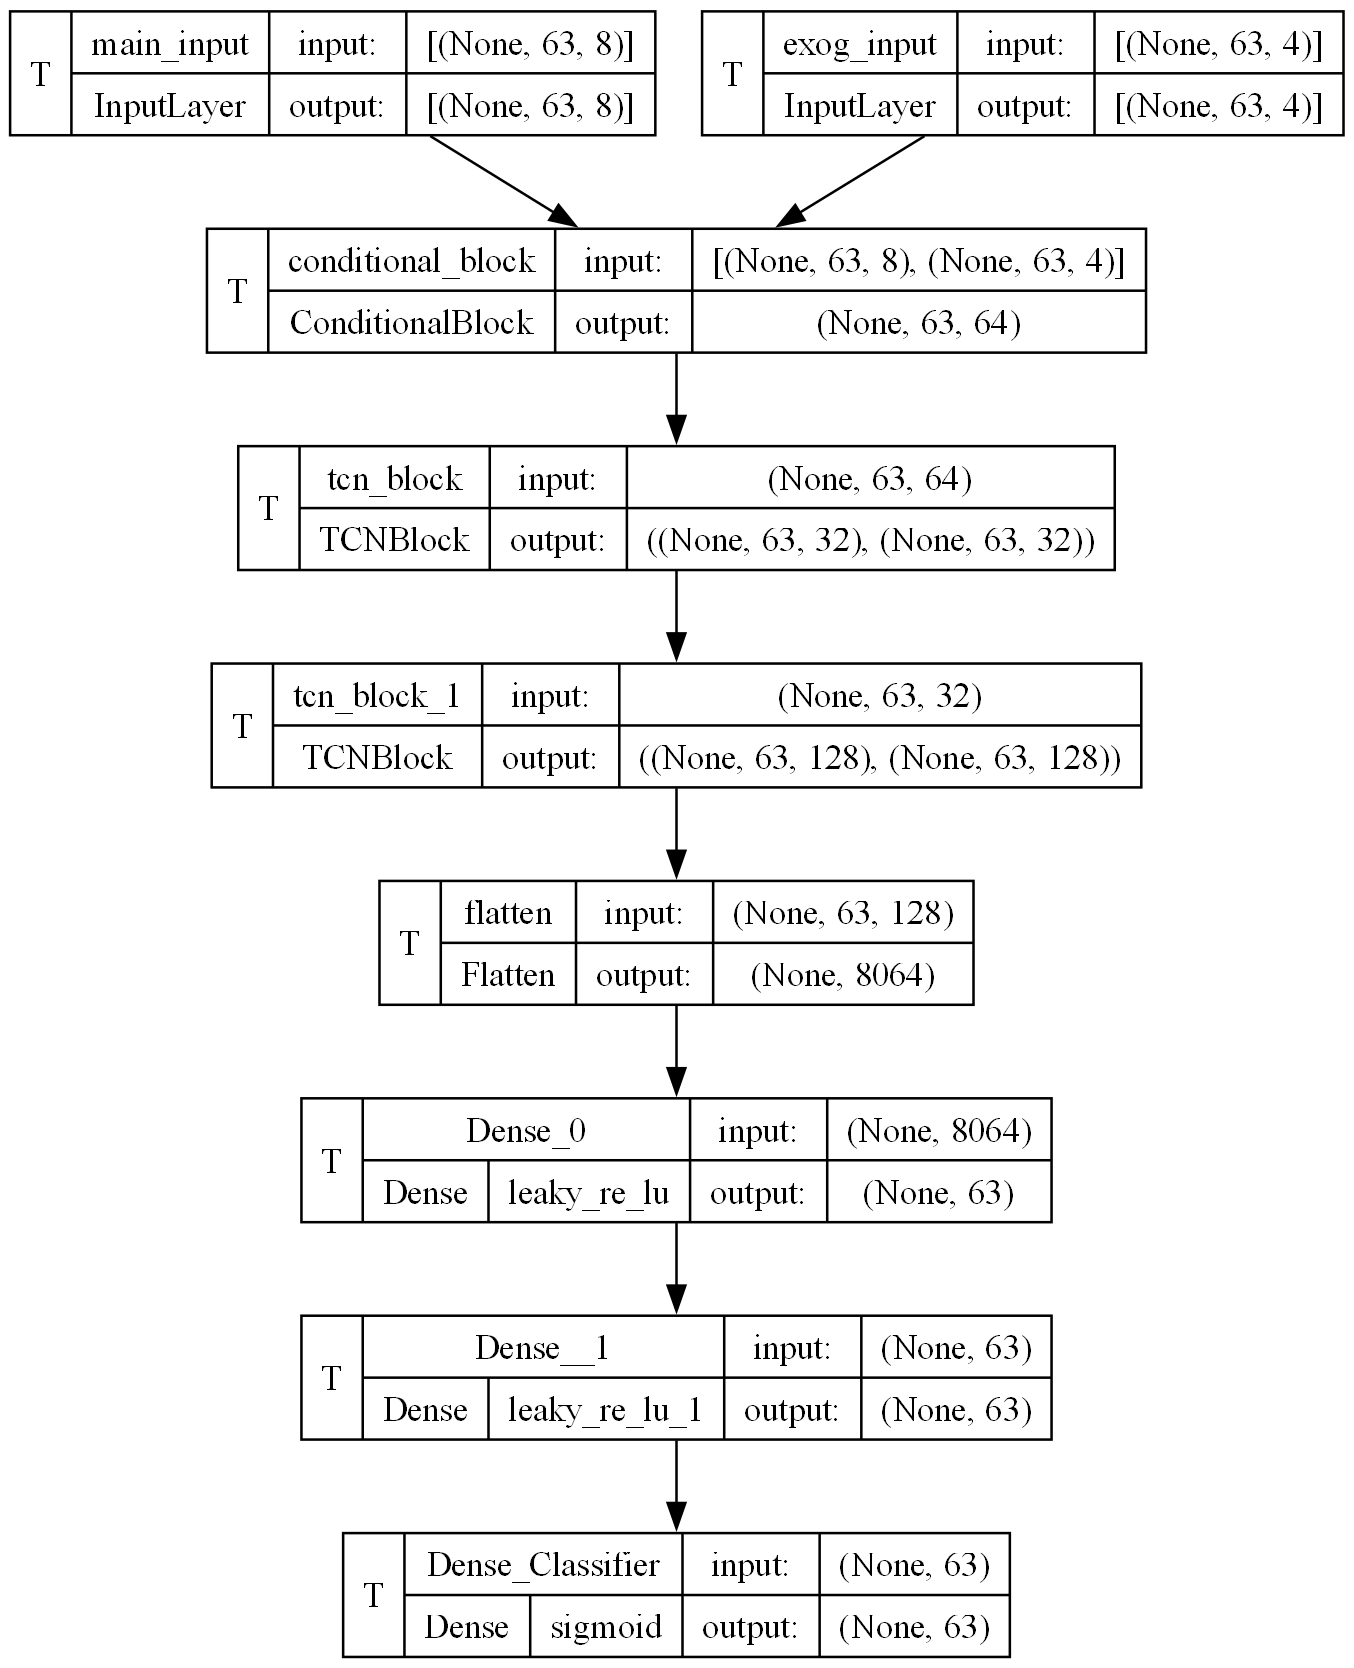

In [23]:
from tensorflow.keras.models import load_model

os.makedirs(MODEL_DIR, exist_ok=True)
assert os.path.exists(MODEL_DIR)

if LOAD_MODEL_CACHE:
    model = load_model(f"{MODEL_DIR}/tcn.h5")
    with open(f"{MODEL_DIR}/history.pkl", 'rb') as file:
        loaded_history = pickle.load(file)
elif not GRID_SEARCH_TRAIN:
     model, history = build_tcn( # Xexog
            input_shape, X=[train_data, train_exog_data], y=ytrain_data, Xt=[test_data, test_exog_data], yt=ytest_data, conditioning_shapes=conditioning_shapes
        )
model.save(f"{MODEL_DIR}/tcn.h5")
tf.keras.utils.plot_model(
    model,
    to_file='./images/tcn_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=102,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True,
)

# model.summary()

# Evaluation

In [24]:
if not IS_CLASSIFICATION and y_scaler is not None:
    ytrain_data = y_scaler.inverse_transform(ytrain_data.reshape(-1, 1))
    ytest_data = y_scaler.inverse_transform(ytest_data.reshape(-1, 1))

assert not np.array_equal(train_data, test_data) and not np.array_equal(train_exog_data, test_exog_data), "Training and test should not be identical."

y_pred = model.predict([train_data, train_exog_data])
yt_pred = model.predict([test_data, test_exog_data])
if IS_CLASSIFICATION:
    y_pred_orig = y_pred.copy()
    yt_pred_orig = yt_pred.copy()
    y_pred = (y_pred > 0.5).astype(int)
    yt_pred = (yt_pred > 0.5).astype(int)
else:
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    yt_pred = y_scaler.inverse_transform(yt_pred.reshape(-1, 1))
print(f"Prediction shape: {yt_pred.shape} vs test data shape: {ytest_data.shape}")
print(f"Test data 1 horizon sample: {ytest_data[0]}")
print(f"Prediction data 1 horizon sample: {yt_pred[0].T}")
print(f"Prediction 1 horizon sample: {yt_pred.flatten()[0]} VS {ytest_data.flatten()[0]}")

23/23 [==============================] - 0s 6ms/step
Prediction shape: (733, 63) vs test data shape: (733, 63)
Test data 1 horizon sample: [0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0]
Prediction data 1 horizon sample: [0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0]
Prediction 1 horizon sample: 0 VS 0


### Confusion Matrices

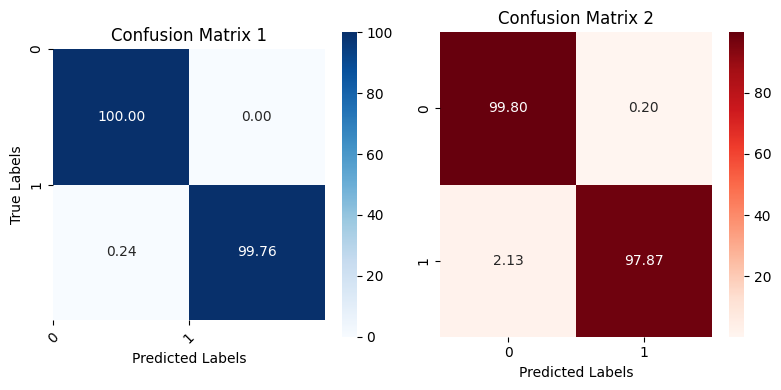

In [25]:
if IS_CLASSIFICATION:

    cm_train = confusion_matrix(ytrain_data.flatten(), y_pred.flatten())
    cm_test = confusion_matrix(ytest_data.flatten(), yt_pred.flatten())

    cm_train_np = cm_train.numpy()
    cm_test_np = cm_test.numpy()

    plot_confusion_matrix(cm_train_np, [0,1], cm_test_np, [0,1])
    plt.show()

shapes y_pred: (4447, 63) and yt_pred: (733, 63)


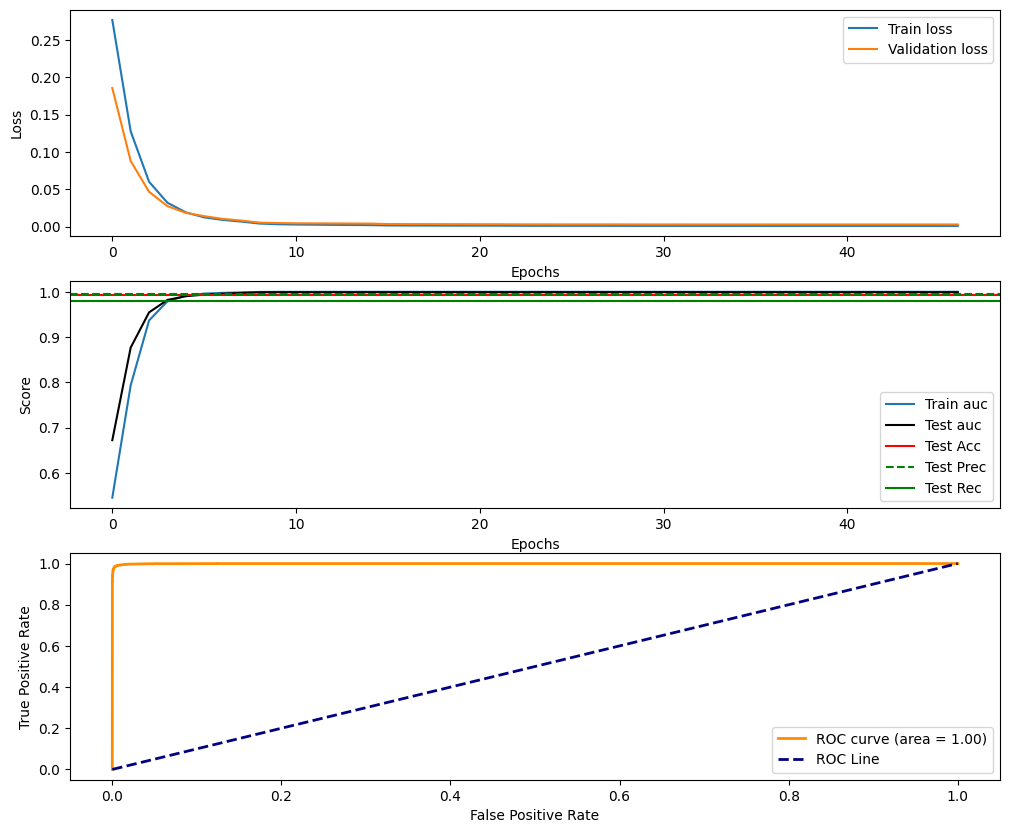

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Test,0.992118,0.995378,0.978696,0.986966,0.999679


In [26]:
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    mean_absolute_error,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, auc
)

def directional_accuracy(y, y_pred):
    a = np.array(y).flatten()
    p = np.array(y_pred).flatten()

    a_dir = np.sign(np.diff(a))
    p_dir = np.sign(np.diff(p))
    correct_dirs = np.sum(a_dir == p_dir)
    acc = correct_dirs / len(a_dir)

    return acc


print(f"shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")

if not IS_CLASSIFICATION:
    mae_train = mean_absolute_error(ytrain_data, y_pred)
    mae_test = mean_absolute_error(ytest_data, yt_pred)
    mse_train = mean_squared_error(ytrain_data, y_pred)
    mse_test = mean_squared_error(ytest_data, yt_pred)
    rmse_train = mean_squared_error(ytrain_data, y_pred, squared=False)
    rmse_test = mean_squared_error(ytest_data, yt_pred, squared=False)
    mape_train = mean_absolute_percentage_error(ytrain_data, y_pred) * 100
    mape_test = mean_absolute_percentage_error(ytest_data, yt_pred) * 100
    r2 = r2_score(
        ytest_data,
        yt_pred,
    )
    da_test = directional_accuracy(ytest_data, yt_pred)
    metrics_df = pd.DataFrame(
        {
            "MAE": [mae_test],
            "MSE": [mse_test],
            "RMSE": [rmse_test],
            "MAPE": [mape_test],
            "R2": [r2],
            "DA": [da_test],
        }
    )
else:
    accuracy_test = accuracy_score(ytest_data.flatten(), yt_pred.flatten())
    precision_test = precision_score(ytest_data.flatten(), yt_pred.flatten())
    recall_test = recall_score(ytest_data.flatten(), yt_pred.flatten())
    f1_test = f1_score(ytest_data.flatten(), yt_pred.flatten())
    roc_auc_test = roc_auc_score(ytest_data.flatten(), yt_pred_orig.flatten())
    metrics_df = pd.DataFrame({
        "Accuracy": [accuracy_test],
        "Precision": [precision_test],
        "Recall": [recall_test],
        "F1 Score": [f1_test],
        "ROC AUC": [roc_auc_test],
    }, index=["Test"])

fig, axs = plt.subplots(3 if IS_CLASSIFICATION else 2, 1, figsize=(12, 10))
axs[0].plot(history.history["loss"], label="Train loss")
axs[0].plot(history.history["val_loss"], label="Validation loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(
    history.history[TARGET_METRIC],
    label=f"Train {TARGET_METRIC}",
)
axs[1].plot(
    history.history[f"val_{TARGET_METRIC}"],
    label=f"Test {TARGET_METRIC}",
    color="k",
)
if not IS_CLASSIFICATION:
    axs[1].axhline(mae_test, color="b", linestyle="--", label="Train Sample MAE")
    axs[1].axhline(mae_train, color="b", linestyle="-", label="Test Sample MAE")
    axs[1].axhline(rmse_train, color="r", linestyle="--", label="Train Sample RMSE")
    axs[1].axhline(rmse_test, color="r", linestyle="-", label="Test Sample RMSE")
else:
    axs[1].axhline(accuracy_test, color="r", linestyle="-", label="Test Acc")
    axs[1].axhline(precision_test, color="g", linestyle="--", label="Test Prec")
    axs[1].axhline(recall_test, color="g", linestyle="-", label="Test Rec")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Score")
axs[1].legend()

if IS_CLASSIFICATION:
    fpr, tpr, _ = roc_curve(ytest_data.flatten(), yt_pred_orig.flatten())
    roc_auc_test = auc(fpr, tpr)
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='ROC Line')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend()

plt.show()

metrics_df

# Walk Forwards

In [27]:
y_oos_pred_raw = model.predict([xtrain_oos, Xexog_oos])
y_oos_pred = (y_oos_pred_raw > 0.5).astype(int)

print(f"Prediction shape: {y_oos_pred.shape} vs test data shape: {y_oos.shape}")
print(f"Test data 1 horizon sample: {y_oos[0]}")
print(f"Predicted data 1 horizon sample: {y_oos_pred[0].T}")
print(f"Prediction 1 horizon sample: {y_oos_pred.flatten()[0]} VS {y_oos.flatten()[0]}")

metrics_oos_df = None
if IS_CLASSIFICATION:
    accuracy_test = accuracy_score(y_oos.flatten(), y_oos_pred.flatten())
    precision_test = precision_score(y_oos.flatten(), y_oos_pred.flatten())
    recall_test = recall_score(y_oos.flatten(), y_oos_pred.flatten())
    f1_test = f1_score(y_oos.flatten(), y_oos_pred.flatten())
    roc_auc_test = roc_auc_score(y_oos.flatten(), y_oos_pred_raw.flatten())
    metrics_oos_df = pd.DataFrame({
        "Accuracy": [accuracy_test],
        "Precision": [precision_test],
        "Recall": [recall_test],
        "F1 Score": [f1_test],
        "ROC AUC": [roc_auc_test],
    }, index=["Test"])

metrics_oos_df

17/17 [==============================] - 0s 6ms/step
Prediction shape: (527, 63) vs test data shape: (527, 63)
Test data 1 horizon sample: [1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1]
Predicted data 1 horizon sample: [1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1]
Prediction 1 horizon sample: 1 VS 1


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Test,0.992741,0.99481,0.98139,0.988055,0.999791


## Cross Validation

In [28]:
from sklearn.model_selection import TimeSeriesSplit
import json
import os

CV_MODEL = True
CV_SPLITS = 3

def train_cv_model(X, y, input_shape, conditioning_shapes=None, n_splits=5, perturb=True):
    def _save_cv(results_df, file_name="cv_results.json"):
        os.makedirs(MODEL_DIR, exist_ok=True)
        file_path = os.path.join(MODEL_DIR, file_name)
        with open(file_path, "w") as file:
            json.dump({"CV results": results_df.to_dict(orient="records")}, file)

    def _perturb_gaussiannoise(X, noise_level=0.1):
        sigma = noise_level * np.std(X)
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

    if perturb:
        X = _perturb_gaussiannoise(X)

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for train_index, test_index in tqdm(tscv.split(X), desc=f"CV Testing for n_splits: {n_splits}"):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        X_train_windows, X_Exog_train, y_train_windows = prepare_windows(X_train, y_train)
        X_test_windows, X_Exog_test, y_test_windows = prepare_windows(X_test, y_test)

        try:
            cv_model, _ = build_tcn(input_shape, [X_train_windows, X_Exog_train], y_train_windows, [X_test_windows, X_Exog_test], y_test_windows, conditioning_shapes=conditioning_shapes, tb=False)
            result = cv_model.evaluate([X_test_windows, X_Exog_test], y_test_windows, verbose=0)
            results.append(result)
        except Exception as e:
            print(f"CV error on fold with exception: {e}")

    metrics_names = [metric.name for metric in cv_model.metrics]
    results_df = pd.DataFrame(results, columns=metrics_names)
    _save_cv(results_df)

    return results_df


if CV_MODEL:
    results_df = train_cv_model(data_df, data_df[TARGET_LABEL], input_shape, conditioning_shapes=conditioning_shapes)
    print(results_df)


Encoding Widows of 63: 100%|██████████| 919/919 [00:00<00:00, 933.93it/s]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.074999873817433e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.8224999621452297e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 5.467499818223587e-07.

Epoch 57: ReduceLROnPlateau reducing learning rate to 1.6402498772549735e-07.

Epoch 64: ReduceLROnPlateau reducing learning rate to 4.920749461234664e-08.

Epoch 71: ReduceLROnPlateau reducing learning rate to 1.4762247957378349e-08.

Epoch 78: ReduceLROnPlateau reducing learning rate to 4.428674493794915e-09.

Epoch 85: ReduceLROnPlateau reducing learning rate to 1.3286022948477693e-09.

Epoch 92: ReduceLROnPlateau reducing learning rate to 3.985

Encoding Widows of 63: 100%|██████████| 919/919 [00:01<00:00, 518.33it/s]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.074999873817433e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.8224999621452297e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 5.467499818223587e-07.

Epoch 57: ReduceLROnPlateau reducing learning rate to 1.6402498772549735e-07.

Epoch 64: ReduceLROnPlateau reducing learning rate to 4.920749461234664e-08.

Epoch 71: ReduceLROnPlateau reducing learning rate to 1.4762247957378349e-08.

Epoch 78: ReduceLROnPlateau reducing learning rate to 4.428674493794915e-09.

Epoch 85: ReduceLROnPlateau reducing learning rate to 1.3286022948477693e-09.


Encoding Widows of 63: 100%|██████████| 919/919 [00:01<00:00, 609.01it/s]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.074999873817433e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.8224999621452297e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 5.467499818223587e-07.

Epoch 57: ReduceLROnPlateau reducing learning rate to 1.6402498772549735e-07.


Encoding Widows of 63: 100%|██████████| 919/919 [00:01<00:00, 829.68it/s]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.074999873817433e-06.


Encoding Widows of 63: 100%|██████████| 919/919 [00:02<00:00, 359.81it/s]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.

Epoch 36: ReduceLROnPlateau reducing learning rate to 6.074999873817433e-06.

Epoch 43: ReduceLROnPlateau reducing learning rate to 1.8224999621452297e-06.

Epoch 50: ReduceLROnPlateau reducing learning rate to 5.467499818223587e-07.


CV Testing for n_splits: 5: 5it [09:50, 118.19s/it]

       loss       auc  binary_crossentropy  binary_accuracy  accuracy
0  0.062622  0.978051             0.213129         0.903933  0.066376
1  0.029585  0.994467             0.114817         0.953728  0.082699
2  0.007456  0.999366             0.029948         0.988687  0.077258
3  0.002896  0.999677             0.013567         0.995337  0.077258
4  0.003028  0.999646             0.019172         0.992901  0.063112


# Predict Today

In [29]:
from datetime import datetime
from pandas.tseries.offsets import BDay

assert model is not None

LAST_TRADING_DAY = pd.Timestamp(datetime.now() - BDay(1))
FIRST_WINDOW_DAY = pd.Timestamp(LAST_TRADING_DAY - BDay(WINDOW_SIZE + 5))
assert len( pd.bdate_range(start=FIRST_WINDOW_DAY, end=LAST_TRADING_DAY)) >= WINDOW_SIZE, f"Expected larger than {WINDOW_SIZE} business days"
print(f"Date ranges {FIRST_WINDOW_DAY} - {LAST_TRADING_DAY}")

pred_tickers = tickers.copy()
for ticker in tickers_symbols:
    df = tickers.get(ticker)
    df = df[(df.index >= latest_start) & (df.index <= earliest_end)]
    assert len(df) > 0 and not df.isna().any().any()
    pred_tickers[ticker] = df
assert len(pred_tickers) > 0 and len(pred_tickers[TARGET_ETF]) > 0

preddata_df, _ = prepare_data(pred_tickers, to_normalize=True)
print(f"Pred Data Shape {preddata_df.shape}")

assert not np.any(pd.isna(preddata_df)) and not np.any(pd.isna(preddata_df))
pred_X, pred_Xexog, _ = prepare_windows(preddata_df, None)

today_pred = model.predict([pred_X, pred_Xexog])
print(f"today_pred Data Shape {today_pred.shape}")
# Remember shape: (Window, Days, features) - in label's case only 1 feature.
print(f"Predicting the {WINDOW_SIZE}th which was yesterday: {today_pred[-1][-2]}")
print(f"Predicting the {WINDOW_SIZE+1}th which is today: {today_pred[-1][-1]}")

Date ranges 2023-11-06 10:29:42.296008 - 2024-02-08 10:29:42.296008
Pred Data Shape (5896, 14)


Encoding Widows of 63: 100%|██████████| 5833/5833 [00:06<00:00, 878.24it/s] 


183/183 [==============================] - 2s 6ms/step
today_pred Data Shape (5833, 63)
Predicting the 63th which was yesterday: 2.894321937674249e-07
Predicting the 64th which is today: 0.8770630359649658


# Unseen Securities Performance

In [30]:
assert model is not None

OHTER_ETFS = ["SSO", "SPXL", "BAC", "TQQQ", "AAPL", "HSBC", "TM"]  # These are leveraged & constituents
LAST_TRADING_DAY_STR = LAST_TRADING_DAY.strftime('%Y-%m-%d')
FIRST_WINDOW_DAY_STR = FIRST_WINDOW_DAY.strftime('%Y-%m-%d')

def generalization_test(unseen_tickers_list, start, end, gen_model=None, input_shape=input_shape, conditioning_shapes=conditioning_shapes):
    metrics_unseen = []
    for ticker in tqdm(unseen_tickers_list, desc="Testing on Unseen TS"):
        current_tickers = tickers.copy()
        other_etf, latest_start, earliest_end = get_tickerdata([ticker], start=start, end=end)
        current_tickers[TARGET_ETF] = other_etf[ticker]
        print(f"Date ranges for {ticker} are {latest_start.strftime('%Y-%m-%d')} - {earliest_end.strftime('%Y-%m-%d')}")

        for ticker_symbol in tickers_symbols:
            df = current_tickers.get(ticker_symbol)
            df = df[(df.index >= latest_start) & (df.index <= earliest_end)]
            assert not df.empty and not df.isna().any().any() and len(df) > WINDOW_SIZE//2, f"Data validation failed for {ticker_symbol}"
            current_tickers[ticker_symbol] = df
        unseendata_df, _ = prepare_data(current_tickers, to_normalize=True)
        assert not np.any(pd.isna(unseendata_df)) and len(unseendata_df) > WINDOW_SIZE//2, "Unseen data preparation failed"
        unseen_X, unseen_Xexog, unseen_y = prepare_windows(unseendata_df, unseendata_df[TARGET_LABEL])

        unseen_ypred_raw = gen_model.predict([unseen_X, unseen_Xexog])
        unseen_pred = (unseen_ypred_raw > 0.5).astype(int)
        metrics = {}
        if IS_CLASSIFICATION:
            metrics = {
                "Accuracy": accuracy_score(unseen_y.flatten(), unseen_pred.flatten()),
                "Precision": precision_score(unseen_y.flatten(), unseen_pred.flatten()),
                "Recall": recall_score(unseen_y.flatten(), unseen_pred.flatten()),
                "F1 Score": f1_score(unseen_y.flatten(), unseen_pred.flatten()),
                "ROC AUC": roc_auc_score(unseen_y.flatten(), unseen_ypred_raw.flatten())
            }
        metrics_unseen.append({ticker: metrics})
    metrics_unseen_df = pd.DataFrame.from_dict({list(d.keys())[0]: list(d.values())[0] for d in metrics_unseen}, orient='index')
    return metrics_unseen_df

metrics_unseen_df = generalization_test(OHTER_ETFS, FIRST_WINDOW_DAY_STR, LAST_TRADING_DAY_STR, gen_model=model)
metrics_unseen_df

Testing on Unseen TS:   0%|          | 0/7 [00:00<?, ?it/s]

SSO => min_date: 2006-06-21 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.03, skewness:1.05, outliers_count:0,  nan_count: 0
Date ranges for SSO are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 500.16it/s]

1/1 [==============================] - 0s 40ms/step



Testing on Unseen TS:  14%|█▍        | 1/7 [00:02<00:13,  2.28s/it]

SPXL => min_date: 2008-11-05 00:00:00, max_date: 2024-02-07 00:00:00, kurt:0.32, skewness:1.06, outliers_count:21,  nan_count: 0
Date ranges for SPXL are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 500.93it/s]

1/1 [==============================] - 0s 36ms/step



Testing on Unseen TS:  29%|██▊       | 2/7 [00:02<00:05,  1.18s/it]

BAC => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.94, skewness:0.12, outliers_count:0,  nan_count: 0
Date ranges for BAC are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 333.15it/s]

1/1 [==============================] - 0s 46ms/step



Testing on Unseen TS:  43%|████▎     | 3/7 [00:03<00:03,  1.08it/s]

TQQQ => min_date: 2010-02-11 00:00:00, max_date: 2024-02-07 00:00:00, kurt:1.94, skewness:1.6, outliers_count:68,  nan_count: 0
Date ranges for TQQQ are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 333.30it/s]

1/1 [==============================] - 0s 29ms/step



Testing on Unseen TS:  57%|█████▋    | 4/7 [00:03<00:02,  1.31it/s]

AAPL => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:1.84, skewness:1.76, outliers_count:65,  nan_count: 0
Date ranges for AAPL are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 995.80it/s]

1/1 [==============================] - 0s 33ms/step



Testing on Unseen TS:  71%|███████▏  | 5/7 [00:04<00:01,  1.44it/s]

HSBC => min_date: 1999-07-16 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.61, skewness:0.5, outliers_count:0,  nan_count: 0
Date ranges for HSBC are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 500.45it/s]

1/1 [==============================] - 0s 31ms/step



Testing on Unseen TS:  86%|████████▌ | 6/7 [00:04<00:00,  1.60it/s]

TM => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.38, skewness:0.44, outliers_count:4,  nan_count: 0
Date ranges for TM are 2023-11-06 - 2024-02-07


Encoding Widows of 63: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]

1/1 [==============================] - 0s 32ms/step



Testing on Unseen TS: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


,Accuracy,Precision,Recall,F1 Score,ROC AUC
SSO,0.968254,1.0,0.923077,0.960000,0.99896
SPXL,1.000000,1.0,1.000000,1.000000,1.00000
BAC,0.984127,1.0,0.952381,0.975610,1.00000
TQQQ,0.984127,1.0,0.965517,0.982456,1.00000
AAPL,1.000000,1.0,1.000000,1.000000,1.00000
HSBC,1.000000,1.0,1.000000,1.000000,1.00000
TM,0.984127,1.0,0.952381,0.975610,1.00000


# Black Swan Performance

In [31]:
assert model is not None

COVID_REGIME_START = "2019-10-01"
COVID_REGIME_END = "2021-01-01"

current_tickers = tickers.copy()
other_etf, latest_start, earliest_end = get_tickerdata([ticker], start=START_DATE, end=COVID_REGIME_END)
current_tickers[TARGET_ETF] = other_etf[ticker]
print(f"Date ranges for {ticker} are {latest_start.strftime('%Y-%m-%d')} - {earliest_end.strftime('%Y-%m-%d')}")

for ticker_symbol in tickers_symbols:
    df = current_tickers.get(ticker_symbol)
    df = df[(df.index >= latest_start) & (df.index <= earliest_end)]
    assert not df.empty and not df.isna().any().any() and len(df) > WINDOW_SIZE//2, f"Data validation failed for {ticker_symbol}"
    current_tickers[ticker_symbol] = df

unseendata_df, _ = prepare_data(current_tickers, to_normalize=True)
unseen_X, unseen_Xexog, unseen_y = prepare_windows(unseendata_df, unseendata_df[TARGET_LABEL])
gen_model, gen_hist = build_tcn(input_shape, [unseen_X, unseen_Xexog], unseen_y, conditioning_shapes=conditioning_shapes, tb=False)
print(f'{TARGET_ETF} val AUC: {gen_hist.history[f"val_{TARGET_METRIC}"][-1]}')

GC=F => min_date: 2000-08-30 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-1.18, skewness:-0.15, outliers_count:0,  nan_count: 0
Date ranges for GC=F are 2000-08-30 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 5038/5038 [00:05<00:00, 886.40it/s]



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0007499999832361936.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00022500000195577739.

Epoch 22: ReduceLROnPlateau reducing learning rate to 6.749999884050339e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 2.024999921559356e-05.
SPY val AUC: 0.9997147917747498


In [32]:

metrics_unseen_df = generalization_test(OHTER_ETFS, START_DATE, COVID_REGIME_END, gen_model=gen_model)
metrics_unseen_df

Testing on Unseen TS:   0%|          | 0/7 [00:00<?, ?it/s]

SSO => min_date: 2006-06-21 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.03, skewness:1.05, outliers_count:0,  nan_count: 0
Date ranges for SSO are 2006-06-21 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 3596/3596 [00:04<00:00, 885.06it/s] 


113/113 [==============================] - 1s 6ms/step


Testing on Unseen TS:  14%|█▍        | 1/7 [00:05<00:34,  5.77s/it]

SPXL => min_date: 2008-11-05 00:00:00, max_date: 2024-02-07 00:00:00, kurt:0.32, skewness:1.06, outliers_count:21,  nan_count: 0
Date ranges for SPXL are 2008-11-05 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 2997/2997 [00:02<00:00, 1149.16it/s]


94/94 [==============================] - 1s 5ms/step


Testing on Unseen TS:  29%|██▊       | 2/7 [00:09<00:22,  4.54s/it]

BAC => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.94, skewness:0.12, outliers_count:0,  nan_count: 0
Date ranges for BAC are 1999-01-04 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 5473/5473 [00:05<00:00, 961.53it/s]


172/172 [==============================] - 1s 6ms/step


Testing on Unseen TS:  43%|████▎     | 3/7 [00:17<00:23,  5.99s/it]

TQQQ => min_date: 2010-02-11 00:00:00, max_date: 2024-02-07 00:00:00, kurt:1.94, skewness:1.6, outliers_count:68,  nan_count: 0
Date ranges for TQQQ are 2010-02-11 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 2679/2679 [00:02<00:00, 1145.85it/s]


84/84 [==============================] - 0s 5ms/step


Testing on Unseen TS:  57%|█████▋    | 4/7 [00:20<00:14,  4.91s/it]

AAPL => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:1.84, skewness:1.76, outliers_count:65,  nan_count: 0
Date ranges for AAPL are 1999-01-04 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 5473/5473 [00:05<00:00, 1045.35it/s]


172/172 [==============================] - 1s 6ms/step


Testing on Unseen TS:  71%|███████▏  | 5/7 [00:27<00:11,  5.77s/it]

HSBC => min_date: 1999-07-16 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.61, skewness:0.5, outliers_count:0,  nan_count: 0
Date ranges for HSBC are 1999-07-16 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 5339/5339 [00:05<00:00, 993.99it/s] 


167/167 [==============================] - 1s 7ms/step


Testing on Unseen TS:  86%|████████▌ | 6/7 [00:35<00:06,  6.39s/it]

TM => min_date: 1999-01-04 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.38, skewness:0.44, outliers_count:4,  nan_count: 0
Date ranges for TM are 1999-01-04 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 5473/5473 [00:05<00:00, 985.95it/s] 


172/172 [==============================] - 1s 5ms/step


Testing on Unseen TS: 100%|██████████| 7/7 [00:42<00:00,  6.11s/it]


,Accuracy,Precision,Recall,F1 Score,ROC AUC
SSO,0.988153,0.994290,0.974371,0.984229,0.999485
SPXL,0.985520,0.994013,0.972289,0.983031,0.999293
BAC,0.989446,0.994782,0.975238,0.984913,0.999585
TQQQ,0.983487,0.993980,0.970199,0.981945,0.999170
AAPL,0.986792,0.994386,0.972377,0.983258,0.999399
HSBC,0.992270,0.996076,0.978421,0.987170,0.999735
TM,0.990165,0.995013,0.975595,0.985209,0.999624


In [33]:
OHTER_ETFS = ["ZM", "SHOP", "VIG", "VOO", "TSLA", "WDI.HM"]  # Including meme stocks and frauds

metrics_unseen_df = generalization_test(OHTER_ETFS, COVID_REGIME_START, COVID_REGIME_END, gen_model=gen_model)
metrics_unseen_df

Testing on Unseen TS:   0%|          | 0/6 [00:00<?, ?it/s]

ZM => min_date: 2019-04-18 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.2, skewness:1.06, outliers_count:2,  nan_count: 0
Date ranges for ZM are 2019-10-01 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 254/254 [00:00<00:00, 1343.94it/s]

8/8 [==============================] - 0s 6ms/step



Testing on Unseen TS:  17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]

SHOP => min_date: 2015-05-20 00:00:00, max_date: 2024-02-07 00:00:00, kurt:0.09, skewness:1.09, outliers_count:0,  nan_count: 0
Date ranges for SHOP are 2019-10-01 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 254/254 [00:00<00:00, 1067.24it/s]


8/8 [==============================] - 0s 6ms/step


Testing on Unseen TS:  33%|███▎      | 2/6 [00:01<00:03,  1.25it/s]

VIG => min_date: 2006-05-02 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.81, skewness:0.68, outliers_count:0,  nan_count: 0
Date ranges for VIG are 2019-10-01 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 254/254 [00:00<00:00, 1289.24it/s]

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 7ms/step


Testing on Unseen TS:  50%|█████     | 3/6 [00:02<00:02,  1.28it/s]

VOO => min_date: 2010-09-09 00:00:00, max_date: 2024-02-07 00:00:00, kurt:-0.97, skewness:0.48, outliers_count:0,  nan_count: 0
Date ranges for VOO are 2019-10-01 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 254/254 [00:00<00:00, 638.19it/s]

1/8 [==>...........................] - ETA: 0s

8/8 [==============================] - 0s 7ms/step


Testing on Unseen TS:  67%|██████▋   | 4/6 [00:03<00:01,  1.11it/s]

TSLA => min_date: 2010-06-29 00:00:00, max_date: 2024-02-07 00:00:00, kurt:0.39, skewness:1.37, outliers_count:13,  nan_count: 0
Date ranges for TSLA are 2019-10-01 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 254/254 [00:00<00:00, 740.53it/s]


8/8 [==============================] - 0s 8ms/step


Testing on Unseen TS:  83%|████████▎ | 5/6 [00:04<00:00,  1.09it/s]

WDI.HM => min_date: 2002-11-11 00:00:00, max_date: 2024-02-07 00:00:00, kurt:3.01, skewness:1.97, outliers_count:96,  nan_count: 0
Date ranges for WDI.HM are 2019-10-01 - 2021-01-01


Encoding Widows of 63: 100%|██████████| 252/252 [00:00<00:00, 984.38it/s]


8/8 [==============================] - 0s 8ms/step


Testing on Unseen TS: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


,Accuracy,Precision,Recall,F1 Score,ROC AUC
ZM,0.979565,0.992292,0.967237,0.979605,0.998776
SHOP,0.985627,0.995444,0.975137,0.985186,0.999293
VIG,0.990001,0.997320,0.972741,0.984877,0.999699
VOO,0.988251,0.995089,0.972575,0.983703,0.999553
TSLA,0.978065,0.992834,0.964107,0.978260,0.998750
WDI.HM,0.988095,0.994963,0.972826,0.983770,0.999559


# Conclusion




![]()

## References

- [YFinance Github](https://github.com/ranaroussi/yfinance)
- [WaveNet: A Generative Model for Raw Audio](https://paperswithcode.com/paper/wavenet-a-generative-model-for-raw-audio)
- [Time series forecasting Tensorflow](https://www.tensorflow.org/tutorials/structured_data/time_series)
- [TensorBoard: TensorFlow's visualization toolkit](https://www.tensorflow.org/tensorboard)
- [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient)
- [Deep Learning for Time Series Forecasting: The Electric Load Case](https://arxiv.org/abs/1907.09207)


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.